<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [1]:
#common libraries
import numpy as np
import os
import math
import random
from collections import OrderedDict

#torch package
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss

#to manage OFF files and transform to voxel grid
!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

#to manage with progression and time in train and evaluate phase 
import time
from tqdm import tqdm

!pip install Pillow==9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 12.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 102.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.0 MB/s eta 0:00:0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 80.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open3d 0.17.0 requires pillow>=9.3.0, but you have pillow 9.0.0 which is incompatible.


# Download and unzip the dataset ModelNet10

In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-05-29 12:11:25--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-05-29 12:11:25--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M   197MB/s    in 2.3s    

2023-05-29 12:11:27 (197 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [4]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135) 
              rotat = 3 
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)

100%|██████████| 101/101 [00:05<00:00, 19.03it/s]


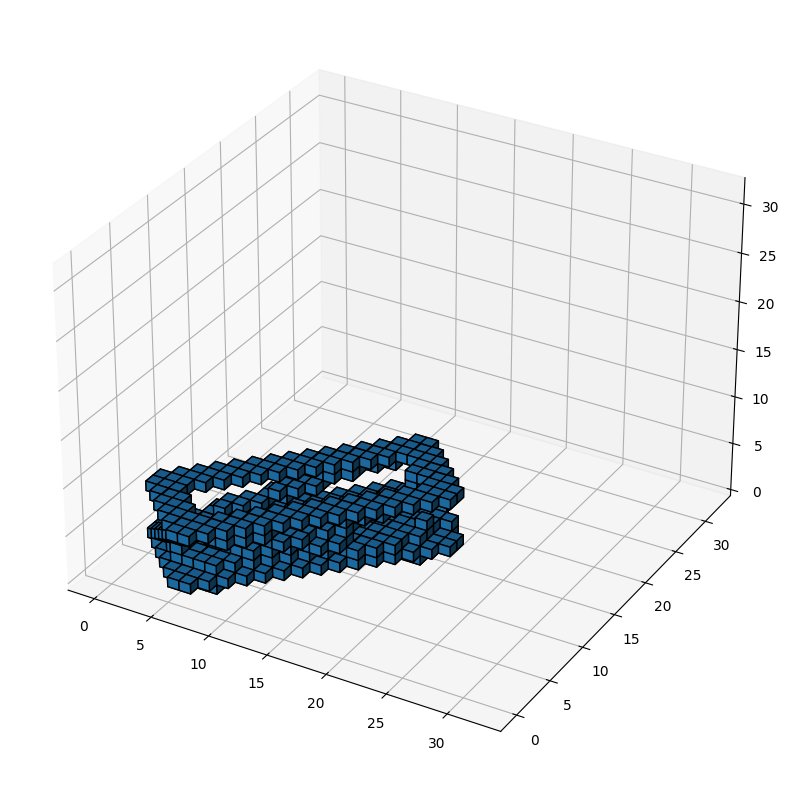

In [ ]:
mesh = o3d.io.read_triangle_mesh('/content/ModelNet10/bathtub/train/bathtub_0003.off')
mesh.rotate(r315)
              
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)

vox_grid = voxel_grid.get_voxels()
vox_g = np.zeros((32, 32, 32), dtype=np.int32)
for i in range (len(vox_grid)):
  voxel_index = vox_grid[i].grid_index
  vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1


ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(vox_g, edgecolor='k')
plt.show()

# Dataset setup and Trainer

In [5]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [6]:
class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
   

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  

                '''
                pred_test1.append(self.model(inputs_test)[0])
                pred_test2.append(self.model(inputs_test)[1])
                pred_test = []
                labels_test = []
                for k in range(0, 25, 8):
                    temp = pred_test1[j]
                    tempo = temp[k:k+7,:]
                    pred_test.append(np.einsum('ij->j', tempo))
                    temp2 = labels_test1
                    labels_test.append(temp2[k])

                pred_test_t = torch.tensor(pred_test)
                labels_test_t = torch.tensor(labels_test)
                pred_test2_t = torch.tensor(pred_test2[j])
                loss_test = self.loss_fn(pred_test_t, labels_test_t) 
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test_t, 1).cpu(), labels_test_t.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2_t, 1).cpu(), labels_test2.cpu())
                pred_choice_test = pred_test_t.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test_t.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test_t, 1))
                self.y_conf.append(labels_test_t)
                '''
                
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=self.num_classes)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

# VoxNet

In [7]:
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, stride=1)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**VoxNet** training

In [9]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.6,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

model VoxNet was chosen
62.359375


Train loss: 1.089272141456604: : 62it [00:10,  6.18it/s]
29it [00:03,  9.49it/s]


epoch:  1 / 50
time: 13.10 seconds
train-loss: 1.47, train-acc-object: 49.42%, train-acc-pose: 39.04%
valid-loss: 1.10, valid-acc-object: 61.45%, train-acc-pose: 56.61%



Train loss: 0.9197743535041809: : 62it [00:10,  6.16it/s]
29it [00:02, 10.51it/s]


epoch:  2 / 50
time: 12.85 seconds
train-loss: 0.89, train-acc-object: 70.44%, train-acc-pose: 60.36%
valid-loss: 0.80, valid-acc-object: 72.80%, train-acc-pose: 58.92%



Train loss: 0.6867786645889282: : 62it [00:10,  6.01it/s]
29it [00:02, 11.70it/s]


epoch:  3 / 50
time: 12.82 seconds
train-loss: 0.69, train-acc-object: 78.10%, train-acc-pose: 67.14%
valid-loss: 0.72, valid-acc-object: 74.89%, train-acc-pose: 63.77%



Train loss: 0.49960702657699585: : 62it [00:10,  5.89it/s]
29it [00:02, 13.60it/s]


epoch:  4 / 50
time: 12.67 seconds
train-loss: 0.58, train-acc-object: 81.07%, train-acc-pose: 72.91%
valid-loss: 0.69, valid-acc-object: 76.21%, train-acc-pose: 67.95%



Train loss: 0.48169854283332825: : 62it [00:10,  5.76it/s]
29it [00:02, 14.43it/s]


epoch:  5 / 50
time: 12.79 seconds
train-loss: 0.54, train-acc-object: 82.26%, train-acc-pose: 74.87%
valid-loss: 0.64, valid-acc-object: 77.86%, train-acc-pose: 68.94%



Train loss: 0.4381936490535736: : 62it [00:10,  5.67it/s]
29it [00:01, 14.66it/s]


epoch:  6 / 50
time: 12.93 seconds
train-loss: 0.44, train-acc-object: 85.94%, train-acc-pose: 77.67%
valid-loss: 0.63, valid-acc-object: 77.75%, train-acc-pose: 68.39%



Train loss: 0.4246874451637268: : 62it [00:10,  5.65it/s]
29it [00:01, 14.69it/s]


epoch:  7 / 50
time: 12.97 seconds
train-loss: 0.39, train-acc-object: 87.98%, train-acc-pose: 80.27%
valid-loss: 0.59, valid-acc-object: 80.07%, train-acc-pose: 70.26%



Train loss: 0.39727962017059326: : 62it [00:10,  5.65it/s]
29it [00:01, 14.58it/s]


epoch:  8 / 50
time: 12.99 seconds
train-loss: 0.36, train-acc-object: 89.57%, train-acc-pose: 80.37%
valid-loss: 0.58, valid-acc-object: 82.16%, train-acc-pose: 71.04%



Train loss: 0.4116717576980591: : 62it [00:11,  5.62it/s]
29it [00:01, 14.56it/s]


epoch:  9 / 50
time: 13.03 seconds
train-loss: 0.34, train-acc-object: 89.42%, train-acc-pose: 82.03%
valid-loss: 0.60, valid-acc-object: 80.73%, train-acc-pose: 73.13%



Train loss: 0.2848844826221466: : 62it [00:10,  5.66it/s]
29it [00:02, 14.24it/s]


epoch: 10 / 50
time: 13.00 seconds
train-loss: 0.32, train-acc-object: 90.55%, train-acc-pose: 83.47%
valid-loss: 0.59, valid-acc-object: 81.61%, train-acc-pose: 71.70%



Train loss: 0.28112295269966125: : 62it [00:10,  5.65it/s]
29it [00:01, 14.52it/s]


epoch: 11 / 50
time: 12.98 seconds
train-loss: 0.28, train-acc-object: 92.49%, train-acc-pose: 83.90%
valid-loss: 0.57, valid-acc-object: 82.60%, train-acc-pose: 74.12%



Train loss: 0.21891340613365173: : 62it [00:10,  5.64it/s]
29it [00:02, 14.36it/s]


epoch: 12 / 50
time: 13.02 seconds
train-loss: 0.26, train-acc-object: 92.77%, train-acc-pose: 85.74%
valid-loss: 0.57, valid-acc-object: 82.93%, train-acc-pose: 73.24%



Train loss: 0.25786250829696655: : 62it [00:11,  5.59it/s]
29it [00:01, 14.70it/s]


epoch: 13 / 50
time: 13.08 seconds
train-loss: 0.24, train-acc-object: 93.20%, train-acc-pose: 86.19%
valid-loss: 0.59, valid-acc-object: 81.50%, train-acc-pose: 73.13%



Train loss: 0.1725826859474182: : 62it [00:10,  5.65it/s]
29it [00:02, 14.38it/s]


epoch: 14 / 50
time: 13.01 seconds
train-loss: 0.24, train-acc-object: 93.93%, train-acc-pose: 86.27%
valid-loss: 0.56, valid-acc-object: 83.15%, train-acc-pose: 73.35%



Train loss: 0.30759376287460327: : 62it [00:11,  5.62it/s]
29it [00:02, 14.40it/s]


epoch: 15 / 50
time: 13.06 seconds
train-loss: 0.22, train-acc-object: 94.23%, train-acc-pose: 86.74%
valid-loss: 0.55, valid-acc-object: 83.26%, train-acc-pose: 74.34%



Train loss: 0.22045017778873444: : 62it [00:11,  5.61it/s]
29it [00:02, 14.12it/s]


epoch: 16 / 50
time: 13.13 seconds
train-loss: 0.20, train-acc-object: 94.68%, train-acc-pose: 87.88%
valid-loss: 0.59, valid-acc-object: 81.94%, train-acc-pose: 75.44%



Train loss: 0.12665608525276184: : 62it [00:11,  5.62it/s]
29it [00:02, 14.36it/s]


epoch: 17 / 50
time: 13.07 seconds
train-loss: 0.19, train-acc-object: 94.81%, train-acc-pose: 88.96%
valid-loss: 0.57, valid-acc-object: 83.04%, train-acc-pose: 75.22%



Train loss: 0.12703418731689453: : 62it [00:11,  5.59it/s]
29it [00:02, 14.29it/s]


epoch: 18 / 50
time: 13.14 seconds
train-loss: 0.19, train-acc-object: 95.24%, train-acc-pose: 88.76%
valid-loss: 0.58, valid-acc-object: 83.59%, train-acc-pose: 74.34%



Train loss: 0.14987415075302124: : 62it [00:10,  5.65it/s]
29it [00:02, 14.04it/s]


epoch: 19 / 50
time: 13.07 seconds
train-loss: 0.19, train-acc-object: 95.41%, train-acc-pose: 87.90%
valid-loss: 0.59, valid-acc-object: 82.82%, train-acc-pose: 74.01%



Train loss: 0.21369172632694244: : 62it [00:11,  5.60it/s]
29it [00:02, 14.21it/s]


epoch: 20 / 50
time: 13.13 seconds
train-loss: 0.19, train-acc-object: 94.96%, train-acc-pose: 89.26%
valid-loss: 0.57, valid-acc-object: 82.71%, train-acc-pose: 74.56%



Train loss: 0.18266907334327698: : 62it [00:11,  5.58it/s]
29it [00:02, 14.36it/s]


epoch: 21 / 50
time: 13.16 seconds
train-loss: 0.16, train-acc-object: 96.02%, train-acc-pose: 89.79%
valid-loss: 0.58, valid-acc-object: 83.81%, train-acc-pose: 74.67%



Train loss: 0.29711002111434937: : 62it [00:11,  5.53it/s]
29it [00:02, 14.01it/s]


epoch: 22 / 50
time: 13.30 seconds
train-loss: 0.17, train-acc-object: 95.72%, train-acc-pose: 90.02%
valid-loss: 0.59, valid-acc-object: 83.48%, train-acc-pose: 74.56%



Train loss: 0.19160838425159454: : 62it [00:11,  5.54it/s]
29it [00:02, 14.31it/s]


epoch: 23 / 50
time: 13.23 seconds
train-loss: 0.16, train-acc-object: 96.14%, train-acc-pose: 90.10%
valid-loss: 0.59, valid-acc-object: 82.71%, train-acc-pose: 74.34%



Train loss: 0.21132948994636536: : 62it [00:11,  5.52it/s]
29it [00:02, 13.73it/s]


epoch: 24 / 50
time: 13.36 seconds
train-loss: 0.16, train-acc-object: 96.35%, train-acc-pose: 89.52%
valid-loss: 0.59, valid-acc-object: 82.71%, train-acc-pose: 74.89%



Train loss: 0.17406323552131653: : 62it [00:10,  5.68it/s]
29it [00:02, 12.59it/s]


epoch: 25 / 50
time: 13.24 seconds
train-loss: 0.15, train-acc-object: 96.02%, train-acc-pose: 90.88%
valid-loss: 0.59, valid-acc-object: 83.26%, train-acc-pose: 75.44%



Train loss: 0.1671610027551651: : 62it [00:10,  5.69it/s]
29it [00:02, 12.14it/s]


epoch: 26 / 50
time: 13.31 seconds
train-loss: 0.15, train-acc-object: 96.55%, train-acc-pose: 90.57%
valid-loss: 0.60, valid-acc-object: 82.27%, train-acc-pose: 75.00%



Train loss: 0.09155958890914917: : 62it [00:10,  5.79it/s]
29it [00:02, 11.46it/s]


epoch: 27 / 50
time: 13.26 seconds
train-loss: 0.15, train-acc-object: 96.57%, train-acc-pose: 90.40%
valid-loss: 0.59, valid-acc-object: 83.48%, train-acc-pose: 75.33%



Train loss: 0.11185876280069351: : 62it [00:10,  5.86it/s]
29it [00:02, 10.71it/s]


epoch: 28 / 50
time: 13.30 seconds
train-loss: 0.16, train-acc-object: 96.35%, train-acc-pose: 90.32%
valid-loss: 0.60, valid-acc-object: 82.49%, train-acc-pose: 75.33%



Train loss: 0.12284527719020844: : 62it [00:10,  5.96it/s]
29it [00:02, 10.16it/s]


epoch: 29 / 50
time: 13.28 seconds
train-loss: 0.14, train-acc-object: 96.85%, train-acc-pose: 91.28%
valid-loss: 0.59, valid-acc-object: 82.38%, train-acc-pose: 75.11%



Train loss: 0.17443059384822845: : 62it [00:10,  5.92it/s]
29it [00:02,  9.87it/s]


epoch: 30 / 50
time: 13.43 seconds
train-loss: 0.14, train-acc-object: 96.82%, train-acc-pose: 91.63%
valid-loss: 0.60, valid-acc-object: 82.71%, train-acc-pose: 75.44%



Train loss: 0.08196701109409332: : 62it [00:10,  5.95it/s]
29it [00:02,  9.69it/s]


epoch: 31 / 50
time: 13.44 seconds
train-loss: 0.14, train-acc-object: 96.70%, train-acc-pose: 91.23%
valid-loss: 0.60, valid-acc-object: 82.16%, train-acc-pose: 75.77%



Train loss: 0.1479898989200592: : 62it [00:10,  6.01it/s]
29it [00:03,  9.47it/s]


epoch: 32 / 50
time: 13.40 seconds
train-loss: 0.14, train-acc-object: 96.45%, train-acc-pose: 91.66%
valid-loss: 0.60, valid-acc-object: 82.71%, train-acc-pose: 75.00%



Train loss: 0.1167832687497139: : 62it [00:10,  6.03it/s]
29it [00:03,  9.39it/s]


epoch: 33 / 50
time: 13.38 seconds
train-loss: 0.14, train-acc-object: 96.37%, train-acc-pose: 91.63%
valid-loss: 0.60, valid-acc-object: 83.04%, train-acc-pose: 75.55%



Train loss: 0.17702531814575195: : 62it [00:10,  6.04it/s]
29it [00:03,  9.07it/s]


epoch: 34 / 50
time: 13.48 seconds
train-loss: 0.13, train-acc-object: 96.98%, train-acc-pose: 92.11%
valid-loss: 0.60, valid-acc-object: 82.71%, train-acc-pose: 75.55%



Train loss: 0.1385652720928192: : 62it [00:10,  6.00it/s]
29it [00:03,  9.14it/s]


epoch: 35 / 50
time: 13.51 seconds
train-loss: 0.13, train-acc-object: 97.15%, train-acc-pose: 91.68%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 75.33%



Train loss: 0.11722813546657562: : 62it [00:10,  5.97it/s]
29it [00:03,  9.05it/s]


epoch: 36 / 50
time: 13.61 seconds
train-loss: 0.13, train-acc-object: 97.33%, train-acc-pose: 92.06%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 75.77%



Train loss: 0.13216529786586761: : 62it [00:10,  6.01it/s]
29it [00:03,  9.11it/s]


epoch: 37 / 50
time: 13.52 seconds
train-loss: 0.13, train-acc-object: 97.05%, train-acc-pose: 91.56%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 75.55%



Train loss: 0.11228704452514648: : 62it [00:10,  6.03it/s]
29it [00:03,  9.19it/s]


epoch: 38 / 50
time: 13.45 seconds
train-loss: 0.14, train-acc-object: 96.52%, train-acc-pose: 91.58%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 75.55%



Train loss: 0.09935524314641953: : 62it [00:10,  5.99it/s]
29it [00:03,  9.11it/s]


epoch: 39 / 50
time: 13.55 seconds
train-loss: 0.13, train-acc-object: 96.85%, train-acc-pose: 91.41%
valid-loss: 0.62, valid-acc-object: 82.82%, train-acc-pose: 76.21%



Train loss: 0.08136890828609467: : 62it [00:10,  5.99it/s]
29it [00:03,  9.15it/s]


epoch: 40 / 50
time: 13.53 seconds
train-loss: 0.13, train-acc-object: 97.05%, train-acc-pose: 91.05%
valid-loss: 0.61, valid-acc-object: 82.38%, train-acc-pose: 75.33%



Train loss: 0.10764988511800766: : 62it [00:10,  5.94it/s]
29it [00:03,  9.27it/s]


epoch: 41 / 50
time: 13.58 seconds
train-loss: 0.13, train-acc-object: 96.65%, train-acc-pose: 91.83%
valid-loss: 0.62, valid-acc-object: 82.71%, train-acc-pose: 75.66%



Train loss: 0.13631919026374817: : 62it [00:10,  5.89it/s]
29it [00:03,  9.32it/s]


epoch: 42 / 50
time: 13.66 seconds
train-loss: 0.13, train-acc-object: 97.35%, train-acc-pose: 91.63%
valid-loss: 0.61, valid-acc-object: 82.71%, train-acc-pose: 75.77%



Train loss: 0.18104664981365204: : 62it [00:10,  5.86it/s]
29it [00:03,  9.64it/s]


epoch: 43 / 50
time: 13.60 seconds
train-loss: 0.13, train-acc-object: 97.18%, train-acc-pose: 90.93%
valid-loss: 0.62, valid-acc-object: 83.04%, train-acc-pose: 75.99%



Train loss: 0.13471539318561554: : 62it [00:10,  5.84it/s]
29it [00:02,  9.91it/s]


epoch: 44 / 50
time: 13.57 seconds
train-loss: 0.13, train-acc-object: 97.03%, train-acc-pose: 91.28%
valid-loss: 0.62, valid-acc-object: 83.15%, train-acc-pose: 76.10%



Train loss: 0.09558534622192383: : 62it [00:10,  5.80it/s]
29it [00:02,  9.87it/s]


epoch: 45 / 50
time: 13.65 seconds
train-loss: 0.13, train-acc-object: 96.93%, train-acc-pose: 91.94%
valid-loss: 0.61, valid-acc-object: 82.82%, train-acc-pose: 75.88%



Train loss: 0.10284305363893509: : 62it [00:10,  5.79it/s]
29it [00:02, 10.01it/s]


epoch: 46 / 50
time: 13.62 seconds
train-loss: 0.13, train-acc-object: 97.05%, train-acc-pose: 91.81%
valid-loss: 0.62, valid-acc-object: 82.93%, train-acc-pose: 75.99%



Train loss: 0.19011688232421875: : 62it [00:10,  5.78it/s]
29it [00:02, 10.15it/s]


epoch: 47 / 50
time: 13.59 seconds
train-loss: 0.13, train-acc-object: 96.90%, train-acc-pose: 91.56%
valid-loss: 0.61, valid-acc-object: 82.82%, train-acc-pose: 76.10%



Train loss: 0.1443493366241455: : 62it [00:10,  5.73it/s]
29it [00:02, 10.25it/s]


epoch: 48 / 50
time: 13.66 seconds
train-loss: 0.13, train-acc-object: 97.18%, train-acc-pose: 91.56%
valid-loss: 0.61, valid-acc-object: 82.82%, train-acc-pose: 75.99%



Train loss: 0.17061111330986023: : 62it [00:10,  5.75it/s]
29it [00:02, 10.49it/s]


epoch: 49 / 50
time: 13.57 seconds
train-loss: 0.13, train-acc-object: 97.08%, train-acc-pose: 91.91%
valid-loss: 0.61, valid-acc-object: 82.82%, train-acc-pose: 75.55%



Train loss: 0.14401647448539734: : 62it [00:10,  5.67it/s]
29it [00:02, 10.51it/s]

epoch: 50 / 50
time: 13.70 seconds
train-loss: 0.13, train-acc-object: 96.93%, train-acc-pose: 92.21%
valid-loss: 0.61, valid-acc-object: 83.04%, train-acc-pose: 75.44%



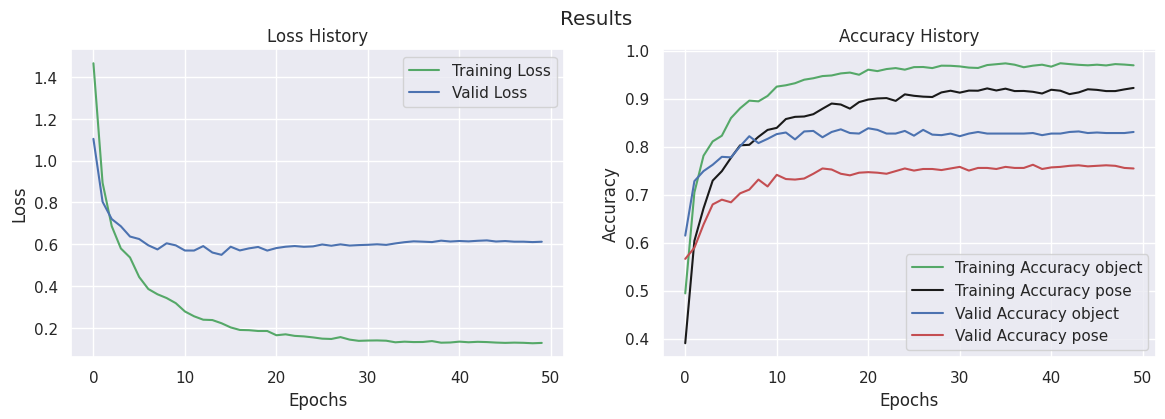

In [10]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

best model was trained at epoch: 21
with a validation loss of: 0.58191496 and a validation accuracy of: 83.81057381629944


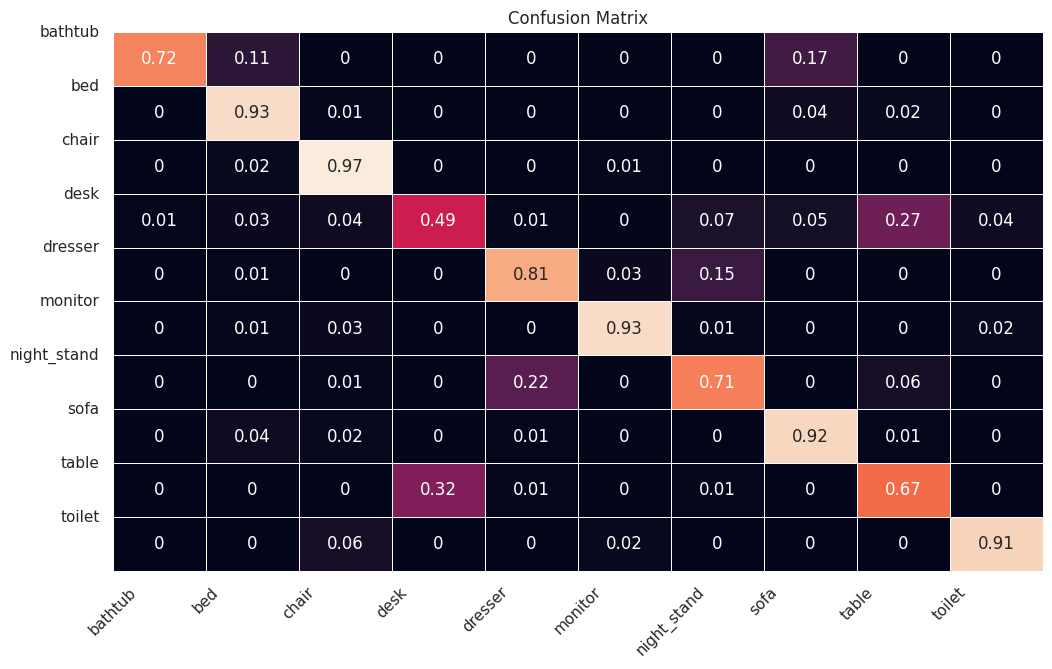

In [11]:
trainer1.generateConfusionMatrix()

best model was trained at epoch: 21
with a validation loss of: 0.58191496 and a validation accuracy of: 83.81057381629944


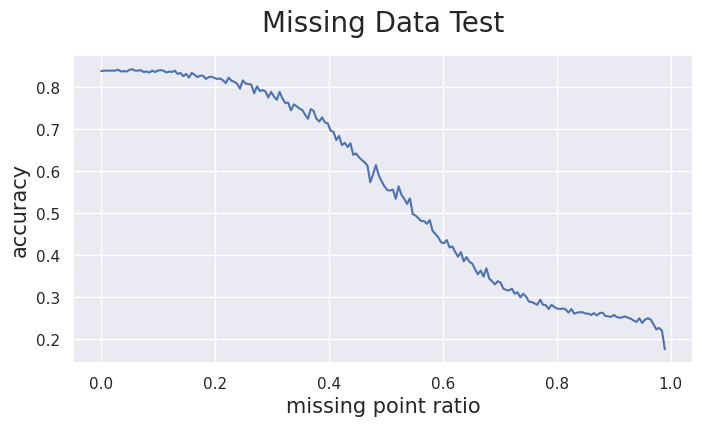

In [12]:
trainer1.missing_data_test()

# BatcNormVoxNet

In [13]:
class BatchNormVoxNet(nn.Module):
    def __init__(self):
        super(BatchNormVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('batch2', torch.nn.BatchNorm3d(64)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('batch3', torch.nn.BatchNorm3d(128)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1)),
            ('batch4', torch.nn.BatchNorm3d(256)),
            ('relu4', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(kernel_size=2, stride=2)),
            ('drop4', torch.nn.Dropout(p=0.3))            
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**BatchNormVoxNet** Training 

In [18]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

model BatchNormVoxNet was chosen
62.359375


Train loss: 1.620307207107544: : 62it [00:18,  3.36it/s]
29it [00:02, 11.45it/s]


epoch:  1 / 50
time: 21.00 seconds
train-loss: 1.71, train-acc-object: 42.97%, train-acc-pose: 29.96%
valid-loss: 1.60, valid-acc-object: 47.47%, train-acc-pose: 45.81%



Train loss: 1.0964571237564087: : 62it [00:19,  3.20it/s]
29it [00:02, 11.61it/s]


epoch:  2 / 50
time: 21.91 seconds
train-loss: 1.34, train-acc-object: 54.81%, train-acc-pose: 43.45%
valid-loss: 1.37, valid-acc-object: 56.06%, train-acc-pose: 51.21%



Train loss: 1.1966497898101807: : 62it [00:18,  3.34it/s]
29it [00:03,  7.60it/s]


epoch:  3 / 50
time: 22.41 seconds
train-loss: 1.18, train-acc-object: 61.06%, train-acc-pose: 49.27%
valid-loss: 1.25, valid-acc-object: 60.57%, train-acc-pose: 54.07%



Train loss: 0.9540612101554871: : 62it [00:18,  3.35it/s]
29it [00:02, 11.64it/s]


epoch:  4 / 50
time: 21.00 seconds
train-loss: 1.07, train-acc-object: 65.25%, train-acc-pose: 52.92%
valid-loss: 1.15, valid-acc-object: 62.00%, train-acc-pose: 57.05%



Train loss: 1.0059311389923096: : 62it [00:19,  3.18it/s]
29it [00:02, 11.46it/s]


epoch:  5 / 50
time: 22.04 seconds
train-loss: 0.97, train-acc-object: 68.62%, train-acc-pose: 55.72%
valid-loss: 1.04, valid-acc-object: 67.18%, train-acc-pose: 57.82%



Train loss: 0.8114284873008728: : 62it [00:18,  3.34it/s]
29it [00:02,  9.73it/s]


epoch:  6 / 50
time: 21.56 seconds
train-loss: 0.88, train-acc-object: 72.03%, train-acc-pose: 59.38%
valid-loss: 0.95, valid-acc-object: 68.94%, train-acc-pose: 60.46%



Train loss: 0.735273540019989: : 62it [00:19,  3.24it/s]
29it [00:02, 11.40it/s]


epoch:  7 / 50
time: 21.67 seconds
train-loss: 0.81, train-acc-object: 74.70%, train-acc-pose: 62.15%
valid-loss: 0.91, valid-acc-object: 70.15%, train-acc-pose: 61.34%



Train loss: 0.9515782594680786: : 62it [00:19,  3.26it/s]
29it [00:03,  9.34it/s]


epoch:  8 / 50
time: 22.16 seconds
train-loss: 0.75, train-acc-object: 76.06%, train-acc-pose: 63.46%
valid-loss: 0.84, valid-acc-object: 72.80%, train-acc-pose: 63.66%



Train loss: 0.49741411209106445: : 62it [00:18,  3.34it/s]
29it [00:02, 11.30it/s]


epoch:  9 / 50
time: 21.17 seconds
train-loss: 0.70, train-acc-object: 78.68%, train-acc-pose: 66.15%
valid-loss: 0.77, valid-acc-object: 74.34%, train-acc-pose: 65.64%



Train loss: 0.5444513559341431: : 62it [00:19,  3.19it/s]
29it [00:02, 11.36it/s]


epoch: 10 / 50
time: 22.00 seconds
train-loss: 0.67, train-acc-object: 80.52%, train-acc-pose: 67.64%
valid-loss: 0.74, valid-acc-object: 74.78%, train-acc-pose: 65.75%



Train loss: 0.49997439980506897: : 62it [00:18,  3.34it/s]
29it [00:03,  7.55it/s]


epoch: 11 / 50
time: 22.43 seconds
train-loss: 0.63, train-acc-object: 81.68%, train-acc-pose: 69.93%
valid-loss: 0.73, valid-acc-object: 75.55%, train-acc-pose: 65.75%



Train loss: 0.708875298500061: : 62it [00:18,  3.31it/s]
29it [00:02, 10.92it/s]


epoch: 12 / 50
time: 21.39 seconds
train-loss: 0.60, train-acc-object: 81.96%, train-acc-pose: 69.46%
valid-loss: 0.69, valid-acc-object: 77.86%, train-acc-pose: 67.40%



Train loss: 0.6207364797592163: : 62it [00:19,  3.17it/s]
29it [00:02, 11.45it/s]


epoch: 13 / 50
time: 22.11 seconds
train-loss: 0.57, train-acc-object: 83.34%, train-acc-pose: 70.39%
valid-loss: 0.66, valid-acc-object: 78.52%, train-acc-pose: 67.29%



Train loss: 0.4932086169719696: : 62it [00:18,  3.33it/s]
29it [00:03,  7.77it/s]


epoch: 14 / 50
time: 22.37 seconds
train-loss: 0.56, train-acc-object: 84.45%, train-acc-pose: 71.90%
valid-loss: 0.66, valid-acc-object: 78.19%, train-acc-pose: 68.39%



Train loss: 0.4381496012210846: : 62it [00:18,  3.32it/s]
29it [00:02, 11.38it/s]


epoch: 15 / 50
time: 21.22 seconds
train-loss: 0.52, train-acc-object: 84.65%, train-acc-pose: 73.14%
valid-loss: 0.64, valid-acc-object: 78.08%, train-acc-pose: 68.28%



Train loss: 0.487379252910614: : 62it [00:19,  3.18it/s]
29it [00:02, 11.14it/s]


epoch: 16 / 50
time: 22.11 seconds
train-loss: 0.50, train-acc-object: 85.61%, train-acc-pose: 73.71%
valid-loss: 0.65, valid-acc-object: 78.52%, train-acc-pose: 68.39%



Train loss: 0.5326950550079346: : 62it [00:18,  3.31it/s]
29it [00:02, 10.05it/s]


epoch: 17 / 50
time: 21.64 seconds
train-loss: 0.50, train-acc-object: 85.08%, train-acc-pose: 74.95%
valid-loss: 0.63, valid-acc-object: 78.96%, train-acc-pose: 71.70%



Train loss: 0.6181604862213135: : 62it [00:19,  3.24it/s]
29it [00:02, 11.37it/s]


epoch: 18 / 50
time: 21.70 seconds
train-loss: 0.48, train-acc-object: 85.79%, train-acc-pose: 74.75%
valid-loss: 0.61, valid-acc-object: 80.07%, train-acc-pose: 70.48%



Train loss: 0.5139718055725098: : 62it [00:18,  3.26it/s]
29it [00:03,  8.59it/s]


epoch: 19 / 50
time: 22.39 seconds
train-loss: 0.46, train-acc-object: 86.74%, train-acc-pose: 75.68%
valid-loss: 0.61, valid-acc-object: 80.51%, train-acc-pose: 69.93%



Train loss: 0.40961119532585144: : 62it [00:18,  3.30it/s]
29it [00:02, 11.36it/s]


epoch: 20 / 50
time: 21.36 seconds
train-loss: 0.45, train-acc-object: 87.27%, train-acc-pose: 75.76%
valid-loss: 0.59, valid-acc-object: 80.95%, train-acc-pose: 71.26%



Train loss: 0.446772038936615: : 62it [00:19,  3.16it/s]
29it [00:02, 11.22it/s]


epoch: 21 / 50
time: 22.23 seconds
train-loss: 0.44, train-acc-object: 87.50%, train-acc-pose: 76.64%
valid-loss: 0.57, valid-acc-object: 80.95%, train-acc-pose: 71.15%



Train loss: 0.41836318373680115: : 62it [00:18,  3.28it/s]
29it [00:03,  7.77it/s]


epoch: 22 / 50
time: 22.64 seconds
train-loss: 0.42, train-acc-object: 88.05%, train-acc-pose: 76.97%
valid-loss: 0.57, valid-acc-object: 83.04%, train-acc-pose: 71.48%



Train loss: 0.40346989035606384: : 62it [00:18,  3.31it/s]
29it [00:02, 11.37it/s]


epoch: 23 / 50
time: 21.32 seconds
train-loss: 0.43, train-acc-object: 87.70%, train-acc-pose: 77.29%
valid-loss: 0.56, valid-acc-object: 82.60%, train-acc-pose: 72.91%



Train loss: 0.42594507336616516: : 62it [00:20,  2.98it/s]
29it [00:04,  5.83it/s]


epoch: 24 / 50
time: 25.83 seconds
train-loss: 0.40, train-acc-object: 89.11%, train-acc-pose: 77.70%
valid-loss: 0.56, valid-acc-object: 82.16%, train-acc-pose: 71.92%



Train loss: 0.3873545229434967: : 62it [00:20,  3.05it/s]
29it [00:02, 11.23it/s]


epoch: 25 / 50
time: 22.91 seconds
train-loss: 0.39, train-acc-object: 89.54%, train-acc-pose: 78.63%
valid-loss: 0.60, valid-acc-object: 80.84%, train-acc-pose: 72.47%



Train loss: 0.3445928692817688: : 62it [00:18,  3.29it/s]
29it [00:03,  7.80it/s]


epoch: 26 / 50
time: 22.59 seconds
train-loss: 0.38, train-acc-object: 89.29%, train-acc-pose: 79.11%
valid-loss: 0.55, valid-acc-object: 83.04%, train-acc-pose: 71.70%



Train loss: 0.2641005218029022: : 62it [00:18,  3.29it/s]
29it [00:02, 11.33it/s]


epoch: 27 / 50
time: 21.42 seconds
train-loss: 0.37, train-acc-object: 89.92%, train-acc-pose: 78.83%
valid-loss: 0.56, valid-acc-object: 81.61%, train-acc-pose: 73.24%



Train loss: 0.384848952293396: : 62it [00:19,  3.14it/s]
29it [00:02, 11.21it/s]


epoch: 28 / 50
time: 22.33 seconds
train-loss: 0.37, train-acc-object: 89.87%, train-acc-pose: 79.49%
valid-loss: 0.55, valid-acc-object: 82.38%, train-acc-pose: 72.14%



Train loss: 0.3399622440338135: : 62it [00:19,  3.21it/s]
29it [00:03,  8.32it/s]


epoch: 29 / 50
time: 22.79 seconds
train-loss: 0.36, train-acc-object: 90.37%, train-acc-pose: 79.89%
valid-loss: 0.55, valid-acc-object: 82.82%, train-acc-pose: 71.04%



Train loss: 0.31787487864494324: : 62it [00:19,  3.26it/s]
29it [00:02, 11.21it/s]


epoch: 30 / 50
time: 21.61 seconds
train-loss: 0.36, train-acc-object: 90.05%, train-acc-pose: 80.09%
valid-loss: 0.53, valid-acc-object: 83.37%, train-acc-pose: 72.91%



Train loss: 0.30928245186805725: : 62it [00:19,  3.14it/s]
29it [00:02, 11.31it/s]


epoch: 31 / 50
time: 22.32 seconds
train-loss: 0.34, train-acc-object: 91.10%, train-acc-pose: 80.57%
valid-loss: 0.54, valid-acc-object: 83.48%, train-acc-pose: 72.47%



Train loss: 0.3882753252983093: : 62it [00:18,  3.29it/s]
29it [00:03,  9.41it/s]


epoch: 32 / 50
time: 21.96 seconds
train-loss: 0.33, train-acc-object: 91.08%, train-acc-pose: 81.50%
valid-loss: 0.53, valid-acc-object: 84.36%, train-acc-pose: 72.91%



Train loss: 0.35627180337905884: : 62it [00:20,  3.08it/s]
29it [00:02, 10.87it/s]


epoch: 33 / 50
time: 22.79 seconds
train-loss: 0.33, train-acc-object: 91.23%, train-acc-pose: 80.80%
valid-loss: 0.54, valid-acc-object: 83.70%, train-acc-pose: 72.36%



Train loss: 0.32808077335357666: : 62it [00:19,  3.15it/s]
29it [00:02, 11.24it/s]


epoch: 34 / 50
time: 22.27 seconds
train-loss: 0.32, train-acc-object: 91.33%, train-acc-pose: 81.65%
valid-loss: 0.54, valid-acc-object: 84.03%, train-acc-pose: 72.58%



Train loss: 0.24123723804950714: : 62it [00:18,  3.28it/s]
29it [00:03,  9.02it/s]


epoch: 35 / 50
time: 22.12 seconds
train-loss: 0.32, train-acc-object: 91.20%, train-acc-pose: 82.03%
valid-loss: 0.55, valid-acc-object: 82.71%, train-acc-pose: 72.58%



Train loss: 0.2263610064983368: : 62it [00:19,  3.24it/s]
29it [00:02, 11.03it/s]


epoch: 36 / 50
time: 21.77 seconds
train-loss: 0.30, train-acc-object: 92.41%, train-acc-pose: 81.63%
valid-loss: 0.54, valid-acc-object: 82.60%, train-acc-pose: 73.02%



Train loss: 0.38100969791412354: : 62it [00:19,  3.14it/s]
29it [00:02, 10.34it/s]


epoch: 37 / 50
time: 22.54 seconds
train-loss: 0.30, train-acc-object: 92.06%, train-acc-pose: 82.38%
valid-loss: 0.54, valid-acc-object: 83.37%, train-acc-pose: 72.14%



Train loss: 0.4207014739513397: : 62it [00:19,  3.26it/s]
29it [00:02,  9.73it/s]


epoch: 38 / 50
time: 22.02 seconds
train-loss: 0.29, train-acc-object: 92.36%, train-acc-pose: 82.86%
valid-loss: 0.56, valid-acc-object: 83.15%, train-acc-pose: 73.90%



Train loss: 0.249475359916687: : 62it [00:19,  3.18it/s]
29it [00:02, 11.10it/s]


epoch: 39 / 50
time: 22.15 seconds
train-loss: 0.29, train-acc-object: 92.67%, train-acc-pose: 82.59%
valid-loss: 0.54, valid-acc-object: 83.59%, train-acc-pose: 72.58%



Train loss: 0.5190134644508362: : 62it [00:19,  3.16it/s]
29it [00:02,  9.89it/s]


epoch: 40 / 50
time: 22.58 seconds
train-loss: 0.29, train-acc-object: 92.06%, train-acc-pose: 82.86%
valid-loss: 0.54, valid-acc-object: 84.14%, train-acc-pose: 72.47%



Train loss: 0.26738035678863525: : 62it [00:19,  3.26it/s]
29it [00:02,  9.84it/s]


epoch: 41 / 50
time: 21.98 seconds
train-loss: 0.27, train-acc-object: 92.92%, train-acc-pose: 83.59%
valid-loss: 0.52, valid-acc-object: 85.35%, train-acc-pose: 73.02%



Train loss: 0.21331146359443665: : 62it [00:19,  3.16it/s]
29it [00:02, 11.07it/s]


epoch: 42 / 50
time: 22.26 seconds
train-loss: 0.27, train-acc-object: 93.35%, train-acc-pose: 83.59%
valid-loss: 0.52, valid-acc-object: 85.35%, train-acc-pose: 73.57%



Train loss: 0.3326566219329834: : 62it [00:19,  3.16it/s]
29it [00:03,  9.51it/s]


epoch: 43 / 50
time: 22.69 seconds
train-loss: 0.26, train-acc-object: 93.52%, train-acc-pose: 84.90%
valid-loss: 0.53, valid-acc-object: 83.59%, train-acc-pose: 73.68%



Train loss: 0.21879757940769196: : 62it [00:18,  3.28it/s]
29it [00:02, 10.57it/s]


epoch: 44 / 50
time: 21.67 seconds
train-loss: 0.25, train-acc-object: 94.38%, train-acc-pose: 83.97%
valid-loss: 0.52, valid-acc-object: 84.80%, train-acc-pose: 73.02%



Train loss: 0.27934110164642334: : 62it [00:19,  3.15it/s]
29it [00:02, 11.09it/s]


epoch: 45 / 50
time: 22.31 seconds
train-loss: 0.26, train-acc-object: 93.88%, train-acc-pose: 84.68%
valid-loss: 0.53, valid-acc-object: 84.14%, train-acc-pose: 73.13%



Train loss: 0.36288994550704956: : 62it [00:19,  3.22it/s]
29it [00:03,  8.72it/s]


epoch: 46 / 50
time: 22.60 seconds
train-loss: 0.25, train-acc-object: 94.00%, train-acc-pose: 84.38%
valid-loss: 0.53, valid-acc-object: 83.81%, train-acc-pose: 72.91%



Train loss: 0.2929874062538147: : 62it [00:18,  3.27it/s]
29it [00:02, 11.17it/s]


epoch: 47 / 50
time: 21.56 seconds
train-loss: 0.26, train-acc-object: 94.00%, train-acc-pose: 83.87%
valid-loss: 0.51, valid-acc-object: 85.02%, train-acc-pose: 73.02%



Train loss: 0.35159754753112793: : 62it [00:19,  3.15it/s]
29it [00:02, 11.13it/s]


epoch: 48 / 50
time: 22.31 seconds
train-loss: 0.24, train-acc-object: 94.18%, train-acc-pose: 84.85%
valid-loss: 0.53, valid-acc-object: 84.03%, train-acc-pose: 74.23%



Train loss: 0.22735030949115753: : 62it [00:19,  3.22it/s]
29it [00:03,  8.29it/s]


epoch: 49 / 50
time: 22.77 seconds
train-loss: 0.25, train-acc-object: 93.90%, train-acc-pose: 85.01%
valid-loss: 0.52, valid-acc-object: 84.58%, train-acc-pose: 73.35%



Train loss: 0.21006307005882263: : 62it [00:18,  3.28it/s]
29it [00:02, 11.22it/s]

epoch: 50 / 50
time: 21.52 seconds
train-loss: 0.25, train-acc-object: 94.08%, train-acc-pose: 84.05%
valid-loss: 0.52, valid-acc-object: 84.69%, train-acc-pose: 73.57%



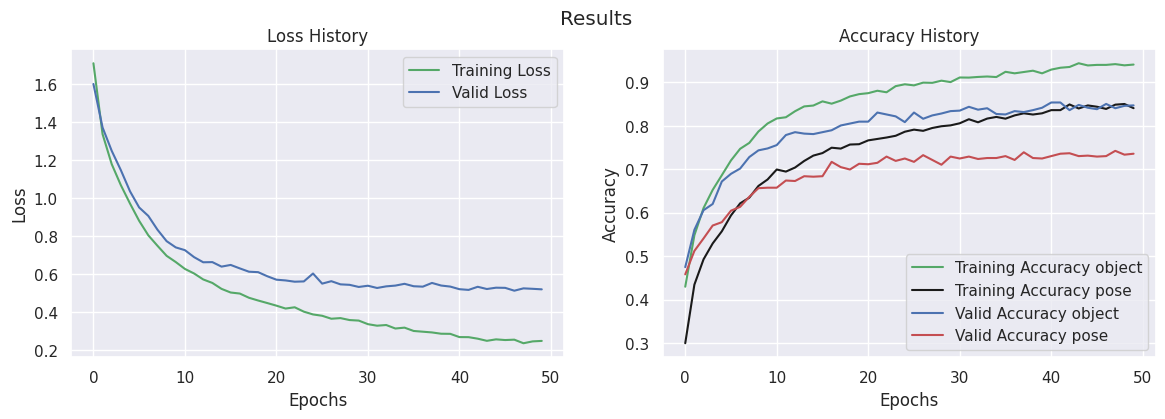

In [19]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

best model was trained at epoch: 41
with a validation loss of: 0.5221587 and a validation accuracy of: 85.35242080688477


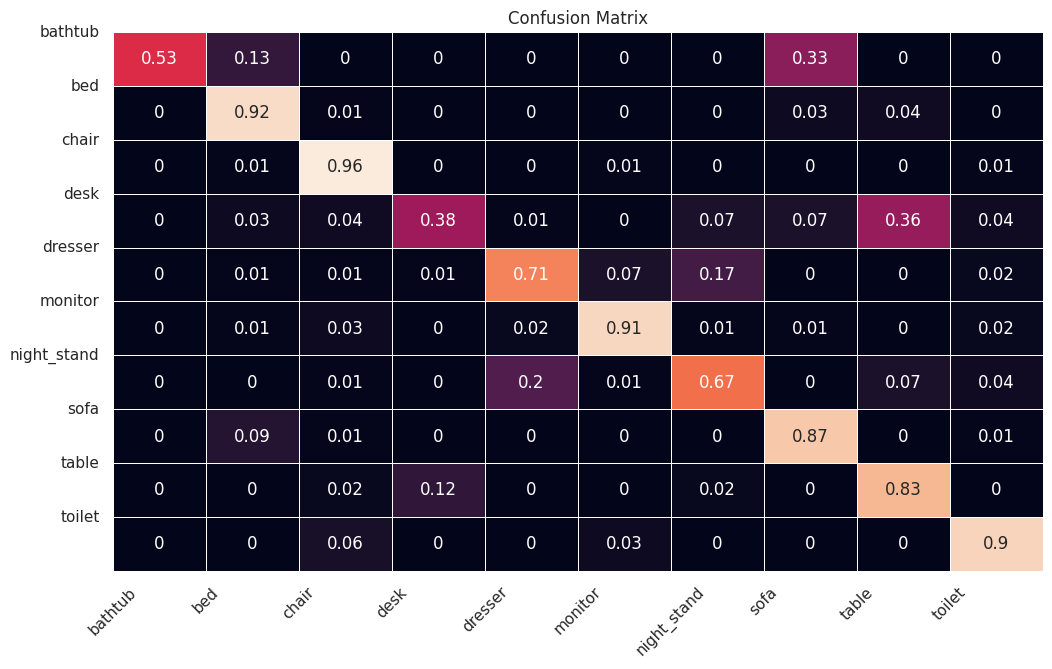

In [20]:
trainer2.generateConfusionMatrix()

best model was trained at epoch: 41
with a validation loss of: 0.5221587 and a validation accuracy of: 85.35242080688477


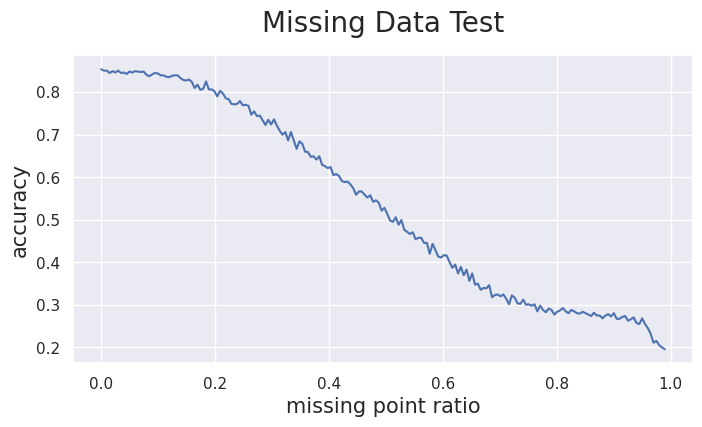

In [21]:
trainer2.missing_data_test()

# DMPVoxNet (double-max-pooling VoxNet)

In [22]:
class DMPVoxNet(nn.Module):
    def __init__(self):
        super(DMPVoxNet, self).__init__()
        n_classes = 10
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('pool1', torch.nn.MaxPool3d(1)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

**DMPVoxNet** training

In [24]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

model DMPVoxNet was choosen
62.359375


Train loss: 1.7773184776306152: : 62it [00:28,  2.18it/s]
29it [00:02,  9.71it/s]


epoch:  1 / 50
time: 31.40 seconds
train-loss: 2.09, train-acc-object: 27.29%, train-acc-pose: 14.99%
valid-loss: 1.94, valid-acc-object: 31.06%, train-acc-pose: 29.07%



Train loss: 1.200709342956543: : 62it [00:28,  2.20it/s]
29it [00:03,  9.59it/s]


epoch:  2 / 50
time: 31.24 seconds
train-loss: 1.49, train-acc-object: 48.56%, train-acc-pose: 38.00%
valid-loss: 1.62, valid-acc-object: 49.23%, train-acc-pose: 46.48%



Train loss: 1.064838171005249: : 62it [00:27,  2.22it/s]
29it [00:04,  6.97it/s]


epoch:  3 / 50
time: 32.14 seconds
train-loss: 1.11, train-acc-object: 62.68%, train-acc-pose: 51.31%
valid-loss: 1.38, valid-acc-object: 58.15%, train-acc-pose: 54.30%



Train loss: 0.7617435455322266: : 62it [00:28,  2.20it/s]
29it [00:02,  9.76it/s]


epoch:  4 / 50
time: 31.17 seconds
train-loss: 0.94, train-acc-object: 68.62%, train-acc-pose: 60.08%
valid-loss: 1.19, valid-acc-object: 66.08%, train-acc-pose: 61.12%



Train loss: 0.5951139330863953: : 62it [00:28,  2.19it/s]
29it [00:03,  9.37it/s]


epoch:  5 / 50
time: 31.37 seconds
train-loss: 0.79, train-acc-object: 73.49%, train-acc-pose: 66.56%
valid-loss: 1.11, valid-acc-object: 69.71%, train-acc-pose: 63.11%



Train loss: 0.4846145510673523: : 62it [00:28,  2.17it/s]
29it [00:03,  8.74it/s]


epoch:  6 / 50
time: 31.93 seconds
train-loss: 0.66, train-acc-object: 78.30%, train-acc-pose: 70.92%
valid-loss: 1.00, valid-acc-object: 70.59%, train-acc-pose: 65.64%



Train loss: 0.6159870624542236: : 62it [00:28,  2.21it/s]
29it [00:02,  9.75it/s]


epoch:  7 / 50
time: 31.06 seconds
train-loss: 0.61, train-acc-object: 79.36%, train-acc-pose: 73.19%
valid-loss: 0.97, valid-acc-object: 74.45%, train-acc-pose: 66.30%



Train loss: 0.43465638160705566: : 62it [00:28,  2.21it/s]
29it [00:03,  7.56it/s]


epoch:  8 / 50
time: 31.96 seconds
train-loss: 0.56, train-acc-object: 81.28%, train-acc-pose: 73.82%
valid-loss: 0.87, valid-acc-object: 75.44%, train-acc-pose: 69.49%



Train loss: 0.4689147174358368: : 62it [00:28,  2.18it/s]
29it [00:03,  9.56it/s]


epoch:  9 / 50
time: 31.49 seconds
train-loss: 0.52, train-acc-object: 83.09%, train-acc-pose: 75.23%
valid-loss: 0.81, valid-acc-object: 76.76%, train-acc-pose: 69.93%



Train loss: 0.38366401195526123: : 62it [00:28,  2.18it/s]
29it [00:03,  9.21it/s]


epoch: 10 / 50
time: 31.58 seconds
train-loss: 0.50, train-acc-object: 84.43%, train-acc-pose: 75.88%
valid-loss: 0.83, valid-acc-object: 78.96%, train-acc-pose: 69.05%



Train loss: 0.49553054571151733: : 62it [00:28,  2.19it/s]
29it [00:04,  7.02it/s]


epoch: 11 / 50
time: 32.45 seconds
train-loss: 0.45, train-acc-object: 85.53%, train-acc-pose: 78.73%
valid-loss: 0.76, valid-acc-object: 80.51%, train-acc-pose: 69.82%



Train loss: 0.5124658942222595: : 62it [00:28,  2.19it/s]
29it [00:02,  9.68it/s]


epoch: 12 / 50
time: 31.33 seconds
train-loss: 0.42, train-acc-object: 86.57%, train-acc-pose: 79.41%
valid-loss: 0.73, valid-acc-object: 81.50%, train-acc-pose: 70.26%



Train loss: 0.4287470579147339: : 62it [00:28,  2.19it/s]
29it [00:03,  8.65it/s]


epoch: 13 / 50
time: 31.63 seconds
train-loss: 0.40, train-acc-object: 87.95%, train-acc-pose: 79.31%
valid-loss: 0.71, valid-acc-object: 82.27%, train-acc-pose: 70.93%



Train loss: 0.4358373284339905: : 62it [00:28,  2.17it/s]
29it [00:03,  9.33it/s]


epoch: 14 / 50
time: 31.76 seconds
train-loss: 0.39, train-acc-object: 88.28%, train-acc-pose: 79.96%
valid-loss: 0.72, valid-acc-object: 80.51%, train-acc-pose: 70.15%



Train loss: 0.3163279891014099: : 62it [00:28,  2.19it/s]
29it [00:03,  9.53it/s]


epoch: 15 / 50
time: 31.38 seconds
train-loss: 0.38, train-acc-object: 87.75%, train-acc-pose: 80.80%
valid-loss: 0.68, valid-acc-object: 82.82%, train-acc-pose: 70.93%



Train loss: 0.3805224895477295: : 62it [00:28,  2.19it/s]
29it [00:04,  6.93it/s]


epoch: 16 / 50
time: 32.48 seconds
train-loss: 0.35, train-acc-object: 89.69%, train-acc-pose: 81.60%
valid-loss: 0.67, valid-acc-object: 82.27%, train-acc-pose: 71.26%



Train loss: 0.3239891231060028: : 62it [00:28,  2.19it/s]
29it [00:03,  9.38it/s]


epoch: 17 / 50
time: 31.41 seconds
train-loss: 0.34, train-acc-object: 89.72%, train-acc-pose: 81.91%
valid-loss: 0.65, valid-acc-object: 82.71%, train-acc-pose: 71.92%



Train loss: 0.26051586866378784: : 62it [00:28,  2.18it/s]
29it [00:03,  9.57it/s]


epoch: 18 / 50
time: 31.45 seconds
train-loss: 0.33, train-acc-object: 89.79%, train-acc-pose: 81.93%
valid-loss: 0.63, valid-acc-object: 83.59%, train-acc-pose: 72.25%



Train loss: 0.3894842267036438: : 62it [00:28,  2.16it/s]
29it [00:03,  7.91it/s]


epoch: 19 / 50
time: 32.40 seconds
train-loss: 0.32, train-acc-object: 89.97%, train-acc-pose: 82.43%
valid-loss: 0.64, valid-acc-object: 83.26%, train-acc-pose: 70.70%



Train loss: 0.3305744528770447: : 62it [00:28,  2.18it/s]
29it [00:03,  9.51it/s]


epoch: 20 / 50
time: 31.45 seconds
train-loss: 0.31, train-acc-object: 90.98%, train-acc-pose: 82.64%
valid-loss: 0.63, valid-acc-object: 85.02%, train-acc-pose: 71.92%



Train loss: 0.36078765988349915: : 62it [00:28,  2.19it/s]
29it [00:03,  7.81it/s]


epoch: 21 / 50
time: 31.99 seconds
train-loss: 0.30, train-acc-object: 91.26%, train-acc-pose: 82.94%
valid-loss: 0.62, valid-acc-object: 83.26%, train-acc-pose: 72.47%



Train loss: 0.3526190221309662: : 62it [00:28,  2.15it/s]
29it [00:03,  9.38it/s]


epoch: 22 / 50
time: 31.99 seconds
train-loss: 0.30, train-acc-object: 91.46%, train-acc-pose: 82.76%
valid-loss: 0.60, valid-acc-object: 84.47%, train-acc-pose: 72.69%



Train loss: 0.292253702878952: : 62it [00:28,  2.17it/s]
29it [00:03,  9.60it/s]


epoch: 23 / 50
time: 31.62 seconds
train-loss: 0.29, train-acc-object: 91.53%, train-acc-pose: 83.82%
valid-loss: 0.60, valid-acc-object: 83.15%, train-acc-pose: 73.90%



Train loss: 0.2741979956626892: : 62it [00:28,  2.18it/s]
29it [00:04,  7.13it/s]


epoch: 24 / 50
time: 32.56 seconds
train-loss: 0.29, train-acc-object: 91.51%, train-acc-pose: 83.29%
valid-loss: 0.60, valid-acc-object: 83.92%, train-acc-pose: 72.91%



Train loss: 0.34227466583251953: : 62it [00:28,  2.18it/s]
29it [00:03,  9.39it/s]


epoch: 25 / 50
time: 31.54 seconds
train-loss: 0.28, train-acc-object: 92.09%, train-acc-pose: 83.80%
valid-loss: 0.60, valid-acc-object: 83.48%, train-acc-pose: 73.79%



Train loss: 0.2811383605003357: : 62it [00:28,  2.20it/s]
29it [00:03,  8.33it/s]


epoch: 26 / 50
time: 31.74 seconds
train-loss: 0.27, train-acc-object: 92.21%, train-acc-pose: 84.58%
valid-loss: 0.59, valid-acc-object: 84.14%, train-acc-pose: 73.35%



Train loss: 0.2663014531135559: : 62it [00:28,  2.16it/s]
29it [00:03,  9.31it/s]


epoch: 27 / 50
time: 31.77 seconds
train-loss: 0.27, train-acc-object: 92.79%, train-acc-pose: 84.25%
valid-loss: 0.58, valid-acc-object: 84.47%, train-acc-pose: 73.46%



Train loss: 0.2405652105808258: : 62it [00:28,  2.19it/s]
29it [00:03,  9.49it/s]


epoch: 28 / 50
time: 31.38 seconds
train-loss: 0.27, train-acc-object: 92.52%, train-acc-pose: 83.87%
valid-loss: 0.58, valid-acc-object: 84.36%, train-acc-pose: 73.68%



Train loss: 0.3097810745239258: : 62it [00:28,  2.20it/s]
29it [00:04,  6.87it/s]


epoch: 29 / 50
time: 32.47 seconds
train-loss: 0.27, train-acc-object: 91.96%, train-acc-pose: 84.32%
valid-loss: 0.59, valid-acc-object: 84.47%, train-acc-pose: 73.57%



Train loss: 0.38109803199768066: : 62it [00:28,  2.19it/s]
29it [00:03,  9.66it/s]


epoch: 30 / 50
time: 31.29 seconds
train-loss: 0.27, train-acc-object: 92.21%, train-acc-pose: 84.10%
valid-loss: 0.58, valid-acc-object: 84.91%, train-acc-pose: 73.68%



Train loss: 0.22142106294631958: : 62it [00:28,  2.19it/s]
29it [00:03,  9.46it/s]


epoch: 31 / 50
time: 31.41 seconds
train-loss: 0.26, train-acc-object: 93.32%, train-acc-pose: 84.65%
valid-loss: 0.58, valid-acc-object: 84.36%, train-acc-pose: 73.24%



Train loss: 0.1500050574541092: : 62it [00:28,  2.16it/s]
29it [00:03,  8.57it/s]


epoch: 32 / 50
time: 32.09 seconds
train-loss: 0.26, train-acc-object: 92.97%, train-acc-pose: 84.32%
valid-loss: 0.58, valid-acc-object: 85.02%, train-acc-pose: 73.46%



Train loss: 0.18773362040519714: : 62it [00:28,  2.19it/s]
29it [00:03,  9.54it/s]


epoch: 33 / 50
time: 31.43 seconds
train-loss: 0.26, train-acc-object: 93.42%, train-acc-pose: 85.18%
valid-loss: 0.58, valid-acc-object: 85.57%, train-acc-pose: 72.58%



Train loss: 0.4049322009086609: : 62it [00:28,  2.19it/s]
29it [00:04,  7.16it/s]


epoch: 34 / 50
time: 32.37 seconds
train-loss: 0.26, train-acc-object: 92.92%, train-acc-pose: 84.35%
valid-loss: 0.58, valid-acc-object: 85.13%, train-acc-pose: 73.24%



Train loss: 0.20731906592845917: : 62it [00:28,  2.17it/s]
29it [00:03,  9.28it/s]


epoch: 35 / 50
time: 31.72 seconds
train-loss: 0.26, train-acc-object: 92.72%, train-acc-pose: 85.18%
valid-loss: 0.58, valid-acc-object: 85.57%, train-acc-pose: 73.90%



Train loss: 0.24164023995399475: : 62it [00:28,  2.19it/s]
29it [00:03,  9.56it/s]


epoch: 36 / 50
time: 31.36 seconds
train-loss: 0.26, train-acc-object: 92.64%, train-acc-pose: 84.65%
valid-loss: 0.58, valid-acc-object: 85.57%, train-acc-pose: 73.68%



Train loss: 0.2967565655708313: : 62it [00:28,  2.18it/s]
29it [00:03,  8.14it/s]


epoch: 37 / 50
time: 32.04 seconds
train-loss: 0.26, train-acc-object: 93.35%, train-acc-pose: 84.40%
valid-loss: 0.58, valid-acc-object: 85.35%, train-acc-pose: 73.02%



Train loss: 0.20633062720298767: : 62it [00:28,  2.19it/s]
29it [00:03,  9.30it/s]


epoch: 38 / 50
time: 31.44 seconds
train-loss: 0.25, train-acc-object: 93.70%, train-acc-pose: 84.78%
valid-loss: 0.57, valid-acc-object: 85.35%, train-acc-pose: 72.80%



Train loss: 0.2541998624801636: : 62it [00:28,  2.17it/s]
29it [00:04,  6.89it/s]


epoch: 39 / 50
time: 32.85 seconds
train-loss: 0.25, train-acc-object: 92.64%, train-acc-pose: 85.74%
valid-loss: 0.57, valid-acc-object: 85.24%, train-acc-pose: 73.02%



Train loss: 0.1641743779182434: : 62it [00:28,  2.15it/s]
29it [00:03,  9.52it/s]


epoch: 40 / 50
time: 31.88 seconds
train-loss: 0.25, train-acc-object: 93.20%, train-acc-pose: 85.48%
valid-loss: 0.57, valid-acc-object: 85.24%, train-acc-pose: 73.02%



Train loss: 0.1640314757823944: : 62it [00:28,  2.18it/s]
29it [00:03,  9.26it/s]


epoch: 41 / 50
time: 31.64 seconds
train-loss: 0.25, train-acc-object: 92.87%, train-acc-pose: 85.86%
valid-loss: 0.57, valid-acc-object: 85.13%, train-acc-pose: 73.24%



Train loss: 0.27308031916618347: : 62it [00:28,  2.16it/s]
29it [00:03,  8.20it/s]


epoch: 42 / 50
time: 32.26 seconds
train-loss: 0.26, train-acc-object: 92.49%, train-acc-pose: 84.53%
valid-loss: 0.57, valid-acc-object: 84.91%, train-acc-pose: 73.24%



Train loss: 0.25539642572402954: : 62it [00:28,  2.19it/s]
29it [00:03,  9.58it/s]


epoch: 43 / 50
time: 31.34 seconds
train-loss: 0.25, train-acc-object: 93.09%, train-acc-pose: 84.85%
valid-loss: 0.57, valid-acc-object: 84.91%, train-acc-pose: 73.02%



Train loss: 0.3274933099746704: : 62it [00:28,  2.18it/s]
29it [00:04,  7.19it/s]


epoch: 44 / 50
time: 32.45 seconds
train-loss: 0.25, train-acc-object: 92.87%, train-acc-pose: 84.90%
valid-loss: 0.57, valid-acc-object: 85.02%, train-acc-pose: 73.24%



Train loss: 0.24644851684570312: : 62it [00:28,  2.18it/s]
29it [00:03,  9.39it/s]


epoch: 45 / 50
time: 31.55 seconds
train-loss: 0.25, train-acc-object: 93.47%, train-acc-pose: 85.79%
valid-loss: 0.57, valid-acc-object: 85.02%, train-acc-pose: 73.13%



Train loss: 0.13948898017406464: : 62it [00:28,  2.18it/s]
29it [00:03,  9.25it/s]


epoch: 46 / 50
time: 31.62 seconds
train-loss: 0.25, train-acc-object: 92.52%, train-acc-pose: 84.90%
valid-loss: 0.57, valid-acc-object: 85.13%, train-acc-pose: 73.02%



Train loss: 0.29689881205558777: : 62it [00:28,  2.16it/s]
29it [00:03,  7.90it/s]


epoch: 47 / 50
time: 32.39 seconds
train-loss: 0.25, train-acc-object: 93.52%, train-acc-pose: 85.11%
valid-loss: 0.57, valid-acc-object: 85.02%, train-acc-pose: 73.13%



Train loss: 0.24527913331985474: : 62it [00:28,  2.18it/s]
29it [00:03,  9.33it/s]


epoch: 48 / 50
time: 31.57 seconds
train-loss: 0.25, train-acc-object: 93.09%, train-acc-pose: 84.50%
valid-loss: 0.57, valid-acc-object: 85.13%, train-acc-pose: 73.13%



Train loss: 0.20349280536174774: : 62it [00:28,  2.18it/s]
29it [00:04,  7.25it/s]


epoch: 49 / 50
time: 32.46 seconds
train-loss: 0.25, train-acc-object: 93.15%, train-acc-pose: 84.58%
valid-loss: 0.57, valid-acc-object: 85.13%, train-acc-pose: 73.02%



Train loss: 0.3909972012042999: : 62it [00:28,  2.17it/s]
29it [00:03,  9.29it/s]


epoch: 50 / 50
time: 31.71 seconds
train-loss: 0.25, train-acc-object: 93.35%, train-acc-pose: 85.01%
valid-loss: 0.57, valid-acc-object: 85.24%, train-acc-pose: 73.35%



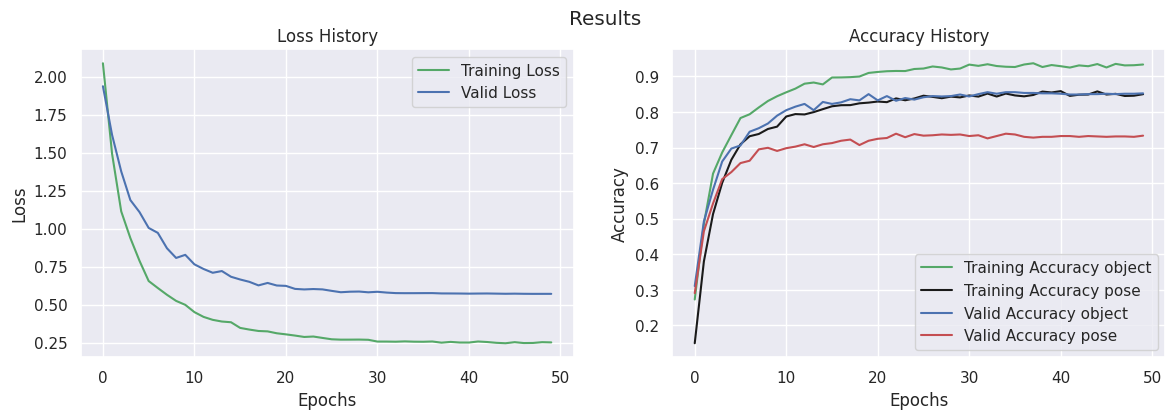

In [25]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

best model was trained at epoch: 33
with a validation loss of: 0.5756701 and a validation accuracy of: 85.57268977165222


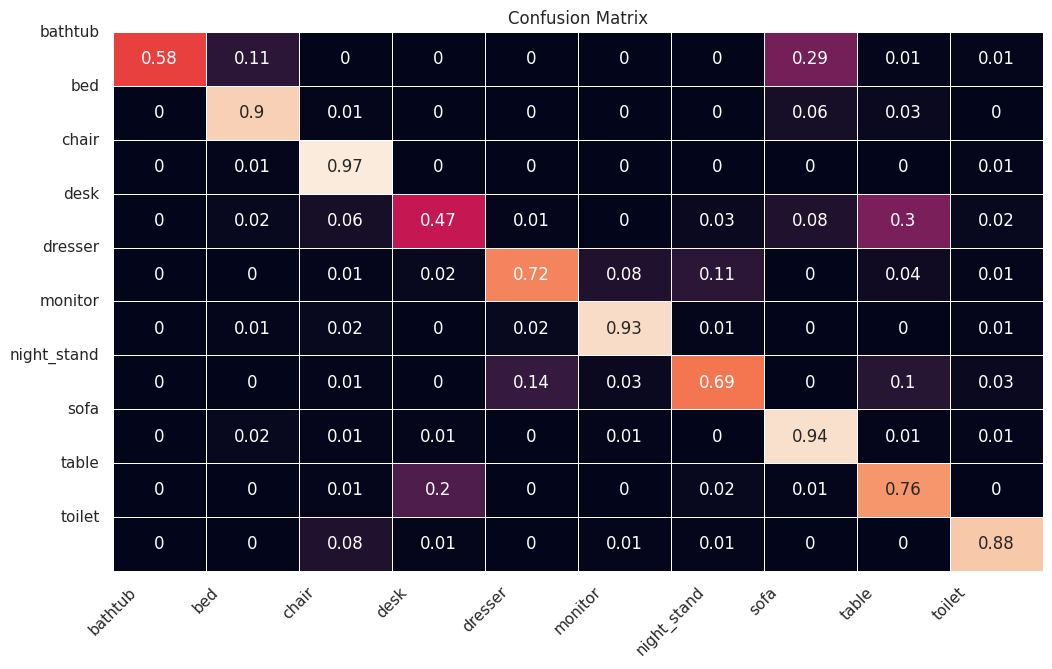

In [26]:
trainer3.generateConfusionMatrix()

best model was trained at epoch: 33
with a validation loss of: 0.5756701 and a validation accuracy of: 85.57268977165222


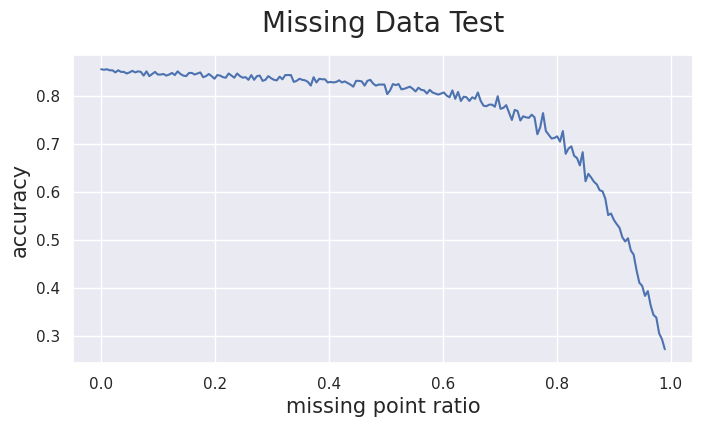

In [27]:
trainer3.missing_data_test()

# VoxNet model comparison

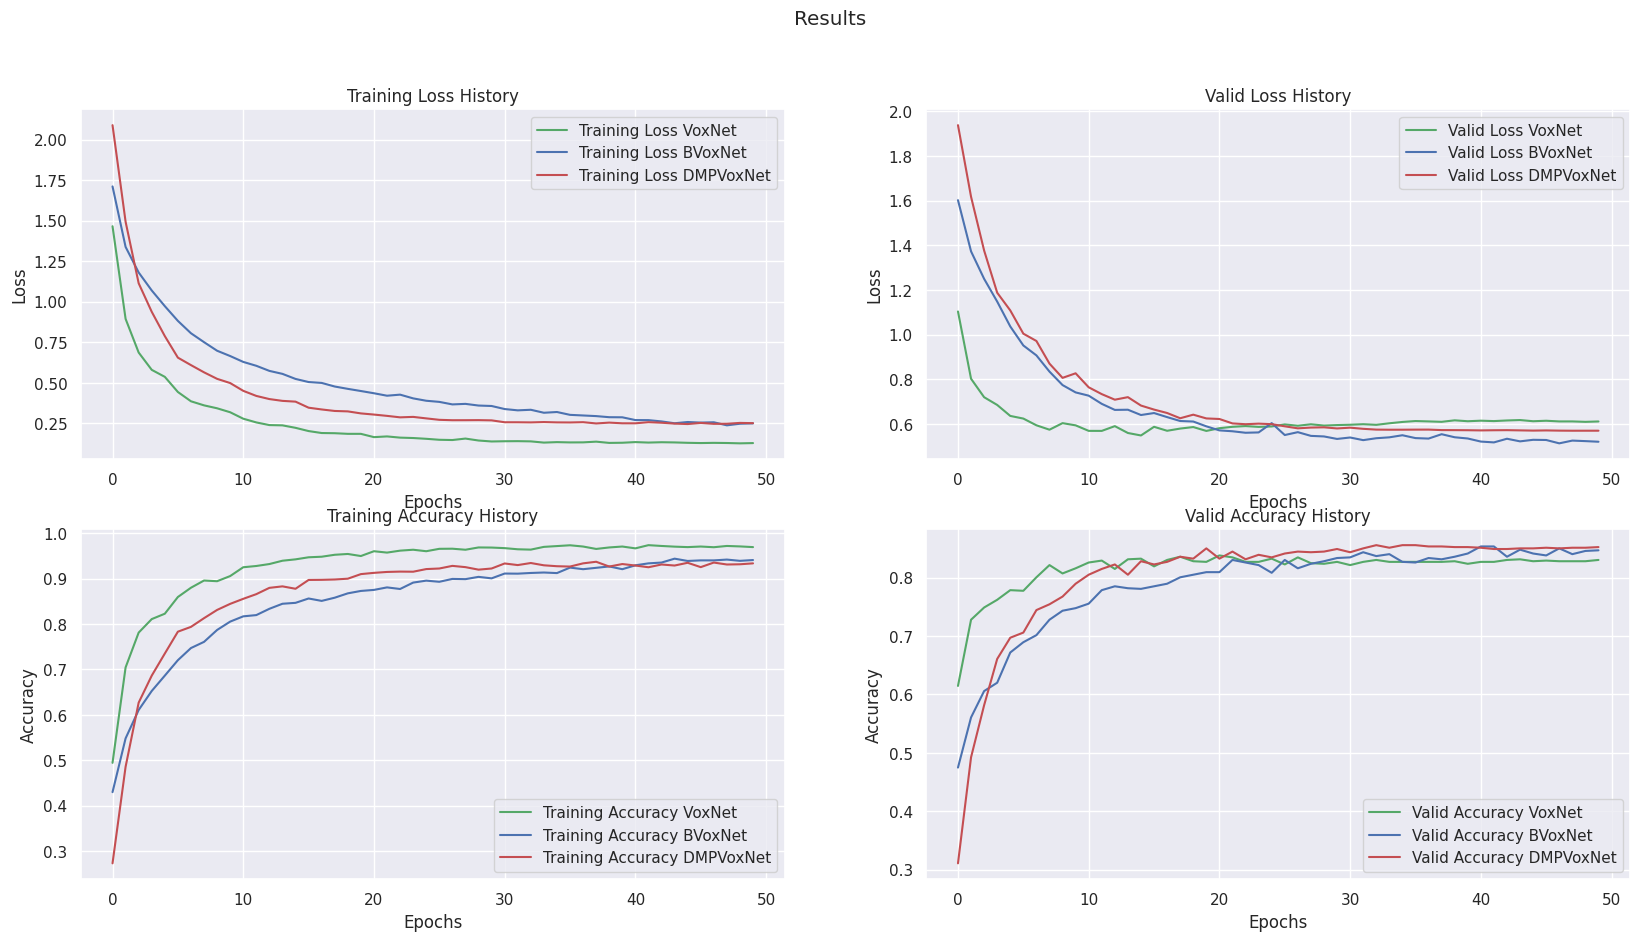

In [28]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history3["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history3["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# Data Augmentation



In [29]:
ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X_a = {'train': [], 'test': []}
Y_a = {'train': [], 'test': []}
Z_a = {'train': [], 'test': []}

for label1, cl in enumerate(CLASSES):
    for label2, rot in enumerate(ROTATIONS):
        split = 'train'
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)[:100]):
            voxel_index = []
            if 'off' in example:
              mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
              if rot == '0':
                mesh = mesh
              elif rot == '45':
                mesh.rotate(r45)
              elif rot == '90':
                mesh.rotate(r90)
              elif rot == '135':
                mesh.rotate(r135)  
              elif rot == '180':
                mesh.rotate(r180)
              elif rot == '225':
                mesh.rotate(r225)
              elif rot == '270':
                mesh.rotate(r270)
              else:
                mesh.rotate(r315)
        
              mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
              voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
            X_a[split].append(voxel_grid)
            Y_a[split].append(label1)
            Z_a[split].append(label2)

for label1, cl in enumerate(CLASSES):
    split = 'test'
    examples_dir = os.path.join(ROOT, cl, split)
    for example in tqdm(os.listdir(examples_dir)):
        voxel_index = []
        rot = random.choice(ROTATIONS)
        if 'off' in example:
          mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
          if rot == '0':
            mesh = mesh
            rotat = 0
          elif rot == '45':
            mesh.rotate(r45)
            rotat = 1
          elif rot == '90':
            mesh.rotate(r90)
            rotat = 2
          elif rot == '135':
            mesh.rotate(r135) 
            rotat = 3 
          elif rot == '180':
            mesh.rotate(r180)
            rotat = 4
          elif rot == '225':
            mesh.rotate(r225)
            rotat = 5
          elif rot == '270':
            mesh.rotate(r270)
            rotat = 6
          else:
            mesh.rotate(r315)
            rotat = 7
          mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
          voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
                
          X_a[split].append(voxel_grid)
          Y_a[split].append(label1)
          Z_a[split].append(rotat)


100%|██████████| 101/101 [00:03<00:00, 28.73it/s]


In [30]:
class VoxelDataset_a(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X_a['train']
          self.label1 = Y_a['train']
          self.label2 = Z_a['train']
      else:
          self.data = X_a['test']
          self.label1 = Y_a['test']
          self.label2 = Z_a['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [31]:
class VoxNet_Trainer_a():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset_a(train=True)
      self.test_ds = VoxelDataset_a(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      if self.name_model == "VoxNet_a":
          self.model = VoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model VoxNet was chosen")
      elif self.name_model == "BatchNormVoxNet_a":
          self.model = BatchNormVoxNet()
          os.mkdir('/content/'+str(self.name_model))
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        os.mkdir('/content/'+str(self.name_model))
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      self.alpha = 2/3
    

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []

          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              #pred_choice = pred.data.max(1)[1]
              #correct = pred_choice.eq(labels.data).cpu().sum()
          self.lr_scheduler.step()
                      
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  

                '''
                pred_test1.append(self.model(inputs_test)[0])
                pred_test2.append(self.model(inputs_test)[1])
                pred_test = []
                labels_test = []
                for k in range(0, 25, 8):
                    temp = pred_test1[j]
                    tempo = temp[k:k+7,:]
                    pred_test.append(np.einsum('ij->j', tempo))
                    temp2 = labels_test1
                    labels_test.append(temp2[k])

                pred_test_t = torch.tensor(pred_test)
                labels_test_t = torch.tensor(labels_test)
                pred_test2_t = torch.tensor(pred_test2[j])
                loss_test = self.loss_fn(pred_test_t, labels_test_t) 
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test_t, 1).cpu(), labels_test_t.cpu())
                valid_accuracy2.update(torch.argmax(pred_test2_t, 1).cpu(), labels_test2.cpu())
                pred_choice_test = pred_test_t.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test_t.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test_t, 1))
                self.y_conf.append(labels_test_t)
                '''
                
                pred_test1, pred_test2 = self.model(inputs_test)  # torch.Size([256, 10])
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                #correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          # total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          ##save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      ##compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [34]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet_a'
}    

trainer4 = VoxNet_Trainer_a(training_hyperparameters)
trainer4.train()

model VoxNet was chosen
125.0


Train loss: 1.4117405414581299: : 125it [00:27,  4.53it/s]
29it [00:03,  8.77it/s]


epoch:  1 / 50
time: 30.92 seconds
train-loss: 1.73, train-acc-object: 36.50%, train-acc-pose: 32.61%
valid-loss: 1.24, valid-acc-object: 60.24%, train-acc-pose: 46.70%



Train loss: 1.1089677810668945: : 125it [00:26,  4.73it/s]
29it [00:03,  9.25it/s]


epoch:  2 / 50
time: 29.57 seconds
train-loss: 1.24, train-acc-object: 56.74%, train-acc-pose: 45.26%
valid-loss: 1.02, valid-acc-object: 66.30%, train-acc-pose: 57.38%



Train loss: 0.9051896333694458: : 125it [00:26,  4.69it/s]
29it [00:02, 11.99it/s]


epoch:  3 / 50
time: 29.07 seconds
train-loss: 1.04, train-acc-object: 64.31%, train-acc-pose: 50.82%
valid-loss: 0.88, valid-acc-object: 68.39%, train-acc-pose: 61.34%



Train loss: 0.6430554389953613: : 125it [00:26,  4.71it/s]
29it [00:02, 11.75it/s]


epoch:  4 / 50
time: 29.02 seconds
train-loss: 0.90, train-acc-object: 70.48%, train-acc-pose: 54.11%
valid-loss: 0.80, valid-acc-object: 72.80%, train-acc-pose: 66.30%



Train loss: 0.9149699807167053: : 125it [00:26,  4.72it/s]
29it [00:02, 11.88it/s]


epoch:  5 / 50
time: 28.92 seconds
train-loss: 0.82, train-acc-object: 74.59%, train-acc-pose: 56.34%
valid-loss: 0.73, valid-acc-object: 74.34%, train-acc-pose: 67.62%



Train loss: 0.6779971122741699: : 125it [00:26,  4.75it/s]
29it [00:02, 12.04it/s]


epoch:  6 / 50
time: 28.76 seconds
train-loss: 0.75, train-acc-object: 76.89%, train-acc-pose: 58.11%
valid-loss: 0.67, valid-acc-object: 77.42%, train-acc-pose: 68.06%



Train loss: 0.6765129566192627: : 125it [00:26,  4.76it/s]
29it [00:03,  8.89it/s]


epoch:  7 / 50
time: 29.53 seconds
train-loss: 0.70, train-acc-object: 79.22%, train-acc-pose: 60.22%
valid-loss: 0.65, valid-acc-object: 77.53%, train-acc-pose: 70.93%



Train loss: 0.8157415390014648: : 125it [00:25,  4.90it/s]
29it [00:03,  9.03it/s]


epoch:  8 / 50
time: 28.73 seconds
train-loss: 0.65, train-acc-object: 80.50%, train-acc-pose: 62.19%
valid-loss: 0.64, valid-acc-object: 77.09%, train-acc-pose: 69.27%



Train loss: 0.6720836162567139: : 125it [00:25,  4.84it/s]
29it [00:02, 12.24it/s]


epoch:  9 / 50
time: 28.20 seconds
train-loss: 0.62, train-acc-object: 81.81%, train-acc-pose: 62.70%
valid-loss: 0.61, valid-acc-object: 79.52%, train-acc-pose: 70.15%



Train loss: 0.6439990401268005: : 125it [00:25,  4.88it/s]
29it [00:02, 12.31it/s]


epoch: 10 / 50
time: 27.98 seconds
train-loss: 0.59, train-acc-object: 82.81%, train-acc-pose: 64.03%
valid-loss: 0.59, valid-acc-object: 80.29%, train-acc-pose: 71.81%



Train loss: 0.5888881683349609: : 125it [00:25,  4.88it/s]
29it [00:02, 12.30it/s]


epoch: 11 / 50
time: 27.97 seconds
train-loss: 0.56, train-acc-object: 84.03%, train-acc-pose: 64.45%
valid-loss: 0.57, valid-acc-object: 80.40%, train-acc-pose: 72.58%



Train loss: 0.5432814359664917: : 125it [00:25,  4.89it/s]
29it [00:02, 12.40it/s]


epoch: 12 / 50
time: 27.90 seconds
train-loss: 0.53, train-acc-object: 85.45%, train-acc-pose: 65.57%
valid-loss: 0.57, valid-acc-object: 80.40%, train-acc-pose: 73.46%



Train loss: 0.48391616344451904: : 125it [00:25,  4.86it/s]
29it [00:02, 12.39it/s]


epoch: 13 / 50
time: 28.09 seconds
train-loss: 0.51, train-acc-object: 85.69%, train-acc-pose: 66.79%
valid-loss: 0.54, valid-acc-object: 82.05%, train-acc-pose: 75.77%



Train loss: 0.48540598154067993: : 125it [00:25,  4.92it/s]
29it [00:02, 12.49it/s]


epoch: 14 / 50
time: 27.76 seconds
train-loss: 0.50, train-acc-object: 86.25%, train-acc-pose: 67.96%
valid-loss: 0.56, valid-acc-object: 80.62%, train-acc-pose: 74.89%



Train loss: 0.47273820638656616: : 125it [00:25,  4.92it/s]
29it [00:02, 12.55it/s]


epoch: 15 / 50
time: 27.74 seconds
train-loss: 0.48, train-acc-object: 87.20%, train-acc-pose: 68.30%
valid-loss: 0.53, valid-acc-object: 81.61%, train-acc-pose: 76.76%



Train loss: 0.4171563386917114: : 125it [00:25,  4.90it/s]
29it [00:02, 12.27it/s]


epoch: 16 / 50
time: 27.90 seconds
train-loss: 0.46, train-acc-object: 88.01%, train-acc-pose: 68.71%
valid-loss: 0.54, valid-acc-object: 82.60%, train-acc-pose: 75.99%



Train loss: 0.49089425802230835: : 125it [00:25,  4.95it/s]
29it [00:02, 10.01it/s]


epoch: 17 / 50
time: 28.15 seconds
train-loss: 0.45, train-acc-object: 88.20%, train-acc-pose: 68.88%
valid-loss: 0.54, valid-acc-object: 82.05%, train-acc-pose: 76.21%



Train loss: 0.4383649230003357: : 125it [00:24,  5.08it/s]
29it [00:03,  8.63it/s]


epoch: 18 / 50
time: 27.97 seconds
train-loss: 0.43, train-acc-object: 88.54%, train-acc-pose: 70.24%
valid-loss: 0.54, valid-acc-object: 81.28%, train-acc-pose: 76.98%



Train loss: 0.35905277729034424: : 125it [00:24,  5.19it/s]
29it [00:03,  8.32it/s]


epoch: 19 / 50
time: 27.59 seconds
train-loss: 0.42, train-acc-object: 89.23%, train-acc-pose: 70.04%
valid-loss: 0.53, valid-acc-object: 82.27%, train-acc-pose: 77.42%



Train loss: 0.33607715368270874: : 125it [00:24,  5.12it/s]
29it [00:03,  9.36it/s]


epoch: 20 / 50
time: 27.53 seconds
train-loss: 0.41, train-acc-object: 89.45%, train-acc-pose: 71.20%
valid-loss: 0.52, valid-acc-object: 82.27%, train-acc-pose: 77.75%



Train loss: 0.42783963680267334: : 125it [00:24,  5.08it/s]
29it [00:02, 10.66it/s]


epoch: 21 / 50
time: 27.36 seconds
train-loss: 0.39, train-acc-object: 90.19%, train-acc-pose: 70.60%
valid-loss: 0.51, valid-acc-object: 82.60%, train-acc-pose: 77.31%



Train loss: 0.5202820897102356: : 125it [00:24,  5.04it/s]
29it [00:02, 11.89it/s]


epoch: 22 / 50
time: 27.25 seconds
train-loss: 0.38, train-acc-object: 90.56%, train-acc-pose: 71.30%
valid-loss: 0.52, valid-acc-object: 82.82%, train-acc-pose: 77.20%



Train loss: 0.3359602093696594: : 125it [00:24,  5.00it/s]
29it [00:02, 12.81it/s]


epoch: 23 / 50
time: 27.27 seconds
train-loss: 0.37, train-acc-object: 91.51%, train-acc-pose: 71.74%
valid-loss: 0.52, valid-acc-object: 83.59%, train-acc-pose: 77.53%



Train loss: 0.3653757572174072: : 125it [00:25,  4.96it/s]
29it [00:02, 12.52it/s]


epoch: 24 / 50
time: 27.56 seconds
train-loss: 0.37, train-acc-object: 91.39%, train-acc-pose: 72.00%
valid-loss: 0.55, valid-acc-object: 81.94%, train-acc-pose: 78.30%



Train loss: 0.3343791961669922: : 125it [00:24,  5.02it/s]
29it [00:02, 12.88it/s]


epoch: 25 / 50
time: 27.16 seconds
train-loss: 0.35, train-acc-object: 91.54%, train-acc-pose: 71.49%
valid-loss: 0.51, valid-acc-object: 83.15%, train-acc-pose: 77.53%



Train loss: 0.28857988119125366: : 125it [00:24,  5.06it/s]
29it [00:02, 12.70it/s]


epoch: 26 / 50
time: 27.01 seconds
train-loss: 0.35, train-acc-object: 92.01%, train-acc-pose: 71.84%
valid-loss: 0.51, valid-acc-object: 83.37%, train-acc-pose: 76.87%



Train loss: 0.33252331614494324: : 125it [00:24,  5.06it/s]
29it [00:02, 12.84it/s]


epoch: 27 / 50
time: 26.97 seconds
train-loss: 0.34, train-acc-object: 92.64%, train-acc-pose: 72.94%
valid-loss: 0.54, valid-acc-object: 82.27%, train-acc-pose: 78.63%



Train loss: 0.4480031728744507: : 125it [00:24,  5.05it/s]
29it [00:02, 12.96it/s]


epoch: 28 / 50
time: 27.02 seconds
train-loss: 0.33, train-acc-object: 92.52%, train-acc-pose: 73.40%
valid-loss: 0.53, valid-acc-object: 82.71%, train-acc-pose: 78.52%



Train loss: 0.37741461396217346: : 125it [00:24,  5.08it/s]
29it [00:02, 12.92it/s]


epoch: 29 / 50
time: 26.86 seconds
train-loss: 0.33, train-acc-object: 92.83%, train-acc-pose: 73.85%
valid-loss: 0.53, valid-acc-object: 82.49%, train-acc-pose: 78.30%



Train loss: 0.2561037540435791: : 125it [00:24,  5.00it/s]
29it [00:02, 11.91it/s]


epoch: 30 / 50
time: 27.44 seconds
train-loss: 0.32, train-acc-object: 93.36%, train-acc-pose: 73.00%
valid-loss: 0.52, valid-acc-object: 83.48%, train-acc-pose: 78.30%



Train loss: 0.29599401354789734: : 125it [00:25,  4.86it/s]
29it [00:02, 11.93it/s]


epoch: 31 / 50
time: 28.15 seconds
train-loss: 0.31, train-acc-object: 92.96%, train-acc-pose: 74.45%
valid-loss: 0.52, valid-acc-object: 82.71%, train-acc-pose: 77.97%



Train loss: 0.32146528363227844: : 125it [00:25,  4.91it/s]
29it [00:02, 12.45it/s]


epoch: 32 / 50
time: 27.80 seconds
train-loss: 0.31, train-acc-object: 93.44%, train-acc-pose: 73.59%
valid-loss: 0.50, valid-acc-object: 84.03%, train-acc-pose: 79.07%



Train loss: 0.2963273823261261: : 125it [00:25,  4.93it/s]
29it [00:02, 12.42it/s]


epoch: 33 / 50
time: 27.70 seconds
train-loss: 0.30, train-acc-object: 93.60%, train-acc-pose: 74.65%
valid-loss: 0.54, valid-acc-object: 82.82%, train-acc-pose: 78.63%



Train loss: 0.3050532639026642: : 125it [00:25,  4.98it/s]
29it [00:02, 12.30it/s]


epoch: 34 / 50
time: 27.46 seconds
train-loss: 0.30, train-acc-object: 93.55%, train-acc-pose: 74.75%
valid-loss: 0.52, valid-acc-object: 83.26%, train-acc-pose: 77.53%



Train loss: 0.27357906103134155: : 125it [00:25,  4.96it/s]
29it [00:02, 12.90it/s]


epoch: 35 / 50
time: 27.46 seconds
train-loss: 0.30, train-acc-object: 93.76%, train-acc-pose: 74.40%
valid-loss: 0.55, valid-acc-object: 82.60%, train-acc-pose: 79.63%



Train loss: 0.25787121057510376: : 125it [00:25,  5.00it/s]
29it [00:02, 12.65it/s]


epoch: 36 / 50
time: 27.32 seconds
train-loss: 0.29, train-acc-object: 93.84%, train-acc-pose: 75.04%
valid-loss: 0.51, valid-acc-object: 83.70%, train-acc-pose: 78.30%



Train loss: 0.24432285130023956: : 125it [00:25,  4.99it/s]
29it [00:02, 12.77it/s]


epoch: 37 / 50
time: 27.35 seconds
train-loss: 0.29, train-acc-object: 94.35%, train-acc-pose: 74.70%
valid-loss: 0.52, valid-acc-object: 83.48%, train-acc-pose: 80.18%



Train loss: 0.24141843616962433: : 125it [00:24,  5.02it/s]
29it [00:02, 12.63it/s]


epoch: 38 / 50
time: 27.20 seconds
train-loss: 0.28, train-acc-object: 94.56%, train-acc-pose: 75.11%
valid-loss: 0.53, valid-acc-object: 83.70%, train-acc-pose: 79.52%



Train loss: 0.2670811712741852: : 125it [00:24,  5.01it/s]
29it [00:02, 11.47it/s]


epoch: 39 / 50
time: 27.51 seconds
train-loss: 0.27, train-acc-object: 94.76%, train-acc-pose: 75.95%
valid-loss: 0.53, valid-acc-object: 84.25%, train-acc-pose: 79.74%



Train loss: 0.20269398391246796: : 125it [00:24,  5.07it/s]
29it [00:02, 10.62it/s]


epoch: 40 / 50
time: 27.41 seconds
train-loss: 0.27, train-acc-object: 94.50%, train-acc-pose: 75.76%
valid-loss: 0.50, valid-acc-object: 83.48%, train-acc-pose: 79.07%



Train loss: 0.2934891879558563: : 125it [00:24,  5.11it/s]
29it [00:02,  9.80it/s]


epoch: 41 / 50
time: 27.42 seconds
train-loss: 0.26, train-acc-object: 95.34%, train-acc-pose: 76.00%
valid-loss: 0.52, valid-acc-object: 84.03%, train-acc-pose: 80.95%



Train loss: 0.3437214195728302: : 125it [00:24,  5.13it/s]
29it [00:03,  9.02it/s]


epoch: 42 / 50
time: 27.60 seconds
train-loss: 0.25, train-acc-object: 95.23%, train-acc-pose: 77.19%
valid-loss: 0.52, valid-acc-object: 84.36%, train-acc-pose: 80.73%



Train loss: 0.2741285562515259: : 125it [00:24,  5.20it/s]
29it [00:03,  8.62it/s]


epoch: 43 / 50
time: 27.43 seconds
train-loss: 0.25, train-acc-object: 95.66%, train-acc-pose: 76.63%
valid-loss: 0.54, valid-acc-object: 83.59%, train-acc-pose: 79.96%



Train loss: 0.20965072512626648: : 125it [00:23,  5.29it/s]
29it [00:03,  8.45it/s]


epoch: 44 / 50
time: 27.06 seconds
train-loss: 0.25, train-acc-object: 95.45%, train-acc-pose: 76.71%
valid-loss: 0.52, valid-acc-object: 84.14%, train-acc-pose: 79.41%



Train loss: 0.30515748262405396: : 125it [00:24,  5.19it/s]
29it [00:03,  8.65it/s]


epoch: 45 / 50
time: 27.46 seconds
train-loss: 0.25, train-acc-object: 95.41%, train-acc-pose: 77.32%
valid-loss: 0.54, valid-acc-object: 83.81%, train-acc-pose: 80.51%



Train loss: 0.23682589828968048: : 125it [00:24,  5.06it/s]
29it [00:03,  9.56it/s]


epoch: 46 / 50
time: 27.75 seconds
train-loss: 0.24, train-acc-object: 95.78%, train-acc-pose: 76.49%
valid-loss: 0.55, valid-acc-object: 83.59%, train-acc-pose: 79.96%



Train loss: 0.3525335490703583: : 125it [00:24,  5.12it/s]
29it [00:02, 10.42it/s]


epoch: 47 / 50
time: 27.23 seconds
train-loss: 0.25, train-acc-object: 95.63%, train-acc-pose: 77.29%
valid-loss: 0.53, valid-acc-object: 83.81%, train-acc-pose: 80.40%



Train loss: 0.21127478778362274: : 125it [00:24,  5.13it/s]
29it [00:02, 10.66it/s]


epoch: 48 / 50
time: 27.10 seconds
train-loss: 0.24, train-acc-object: 95.84%, train-acc-pose: 77.15%
valid-loss: 0.53, valid-acc-object: 83.59%, train-acc-pose: 80.84%



Train loss: 0.17491017282009125: : 125it [00:24,  5.15it/s]
29it [00:02, 10.92it/s]


epoch: 49 / 50
time: 26.96 seconds
train-loss: 0.24, train-acc-object: 95.92%, train-acc-pose: 77.31%
valid-loss: 0.54, valid-acc-object: 83.48%, train-acc-pose: 80.29%



Train loss: 0.17196139693260193: : 125it [00:24,  5.18it/s]
29it [00:02, 10.72it/s]

epoch: 50 / 50
time: 26.86 seconds
train-loss: 0.24, train-acc-object: 95.76%, train-acc-pose: 77.85%
valid-loss: 0.57, valid-acc-object: 83.15%, train-acc-pose: 80.40%



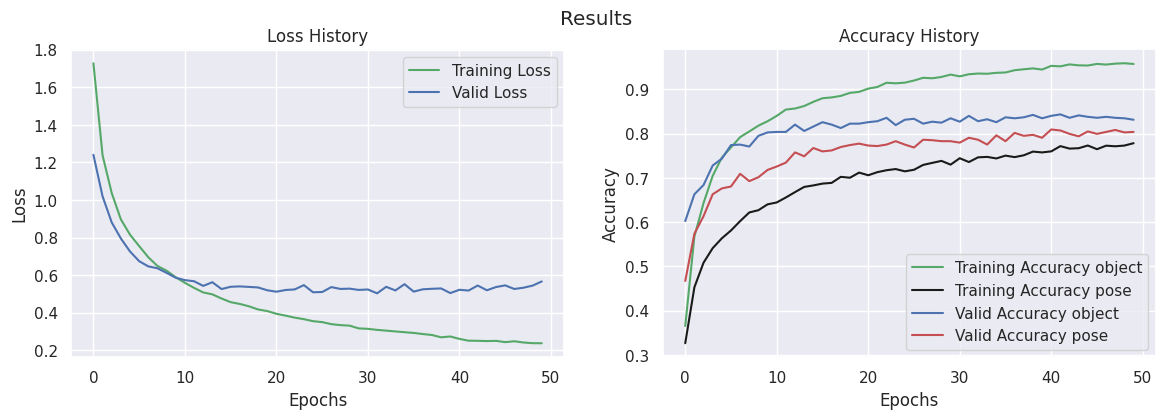

In [35]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history4 = trainer4.getHistory()
trainer4.showResults()

best model was trained at epoch: 42
with a validation loss of: 0.5178842 and a validation accuracy of: 84.36123132705688


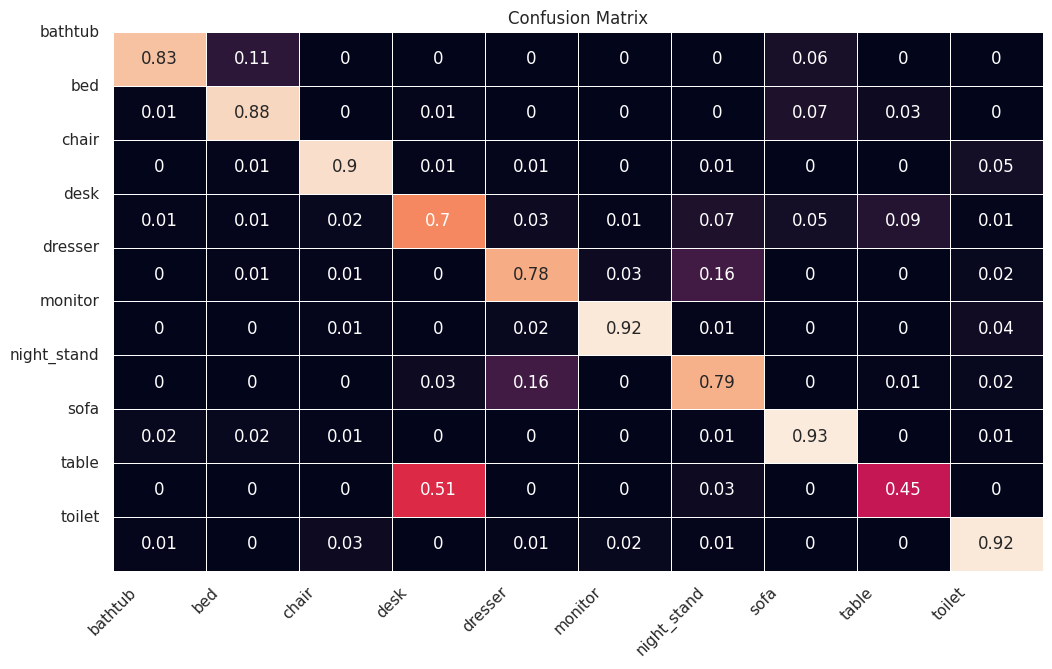

In [36]:
trainer4.generateConfusionMatrix()

best model was trained at epoch: 42
with a validation loss of: 0.5178842 and a validation accuracy of: 84.36123132705688


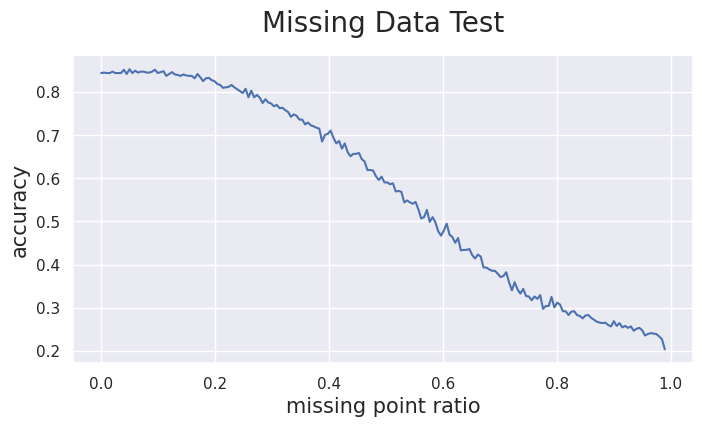

In [37]:
trainer4.missing_data_test()

In [38]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 40,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet_a'
}    

trainer5 = VoxNet_Trainer_a(training_hyperparameters)
trainer5.train()

model BatchNormVoxNet was chosen
125.0


Train loss: 1.4340522289276123: : 125it [00:41,  2.98it/s]
29it [00:02, 10.16it/s]


epoch:  1 / 50
time: 44.82 seconds
train-loss: 1.67, train-acc-object: 36.63%, train-acc-pose: 34.67%
valid-loss: 1.39, valid-acc-object: 56.61%, train-acc-pose: 48.90%



Train loss: 1.176469326019287: : 125it [00:41,  3.03it/s]
29it [00:02, 10.22it/s]


epoch:  2 / 50
time: 44.11 seconds
train-loss: 1.26, train-acc-object: 54.44%, train-acc-pose: 44.80%
valid-loss: 1.12, valid-acc-object: 64.54%, train-acc-pose: 52.42%



Train loss: 0.9203472137451172: : 125it [00:41,  3.04it/s]
29it [00:03,  7.52it/s]


epoch:  3 / 50
time: 45.04 seconds
train-loss: 1.03, train-acc-object: 65.19%, train-acc-pose: 49.52%
valid-loss: 0.92, valid-acc-object: 71.81%, train-acc-pose: 58.15%



Train loss: 0.8523044586181641: : 125it [00:41,  3.01it/s]
29it [00:02, 10.53it/s]


epoch:  4 / 50
time: 44.26 seconds
train-loss: 0.90, train-acc-object: 71.78%, train-acc-pose: 53.69%
valid-loss: 0.82, valid-acc-object: 74.89%, train-acc-pose: 64.54%



Train loss: 0.8320239782333374: : 125it [00:41,  3.03it/s]
29it [00:02, 10.01it/s]


epoch:  5 / 50
time: 44.23 seconds
train-loss: 0.81, train-acc-object: 75.49%, train-acc-pose: 55.08%
valid-loss: 0.73, valid-acc-object: 79.41%, train-acc-pose: 67.62%



Train loss: 0.6385464668273926: : 125it [00:41,  3.04it/s]
29it [00:04,  7.24it/s]


epoch:  6 / 50
time: 45.08 seconds
train-loss: 0.75, train-acc-object: 77.35%, train-acc-pose: 57.55%
valid-loss: 0.71, valid-acc-object: 76.65%, train-acc-pose: 65.86%



Train loss: 0.743560254573822: : 125it [00:40,  3.05it/s]
29it [00:02, 10.41it/s]


epoch:  7 / 50
time: 43.73 seconds
train-loss: 0.70, train-acc-object: 79.20%, train-acc-pose: 59.51%
valid-loss: 0.69, valid-acc-object: 77.09%, train-acc-pose: 67.51%



Train loss: 0.723429799079895: : 125it [00:41,  3.04it/s]
29it [00:02, 10.20it/s]


epoch:  8 / 50
time: 44.01 seconds
train-loss: 0.67, train-acc-object: 79.90%, train-acc-pose: 60.80%
valid-loss: 0.63, valid-acc-object: 79.96%, train-acc-pose: 69.16%



Train loss: 0.7490752339363098: : 125it [00:41,  3.01it/s]
29it [00:04,  6.96it/s]


epoch:  9 / 50
time: 45.66 seconds
train-loss: 0.64, train-acc-object: 81.50%, train-acc-pose: 62.31%
valid-loss: 0.61, valid-acc-object: 79.52%, train-acc-pose: 70.26%



Train loss: 0.5036752223968506: : 125it [00:41,  3.02it/s]
29it [00:02, 10.06it/s]


epoch: 10 / 50
time: 44.27 seconds
train-loss: 0.60, train-acc-object: 82.85%, train-acc-pose: 62.71%
valid-loss: 0.59, valid-acc-object: 81.06%, train-acc-pose: 72.03%



Train loss: 0.5885382890701294: : 125it [00:41,  3.04it/s]
29it [00:02, 10.45it/s]


epoch: 11 / 50
time: 43.87 seconds
train-loss: 0.57, train-acc-object: 83.86%, train-acc-pose: 64.30%
valid-loss: 0.58, valid-acc-object: 80.07%, train-acc-pose: 71.92%



Train loss: 0.6737192869186401: : 125it [00:41,  3.03it/s]
29it [00:04,  7.20it/s]


epoch: 12 / 50
time: 45.34 seconds
train-loss: 0.56, train-acc-object: 84.04%, train-acc-pose: 63.81%
valid-loss: 0.55, valid-acc-object: 81.72%, train-acc-pose: 73.02%



Train loss: 0.41062965989112854: : 125it [00:42,  2.96it/s]
29it [00:03,  9.55it/s]


epoch: 13 / 50
time: 45.22 seconds
train-loss: 0.53, train-acc-object: 85.40%, train-acc-pose: 65.14%
valid-loss: 0.55, valid-acc-object: 81.72%, train-acc-pose: 73.24%



Train loss: 0.424081027507782: : 125it [00:42,  2.96it/s]
29it [00:03,  7.67it/s]


epoch: 14 / 50
time: 46.10 seconds
train-loss: 0.51, train-acc-object: 85.86%, train-acc-pose: 66.36%
valid-loss: 0.57, valid-acc-object: 79.63%, train-acc-pose: 74.23%



Train loss: 0.5150014162063599: : 125it [00:42,  2.91it/s]
29it [00:03,  9.49it/s]


epoch: 15 / 50
time: 46.04 seconds
train-loss: 0.48, train-acc-object: 87.15%, train-acc-pose: 66.61%
valid-loss: 0.55, valid-acc-object: 81.61%, train-acc-pose: 75.33%



Train loss: 0.43050259351730347: : 125it [00:42,  2.93it/s]
29it [00:03,  9.07it/s]


epoch: 16 / 50
time: 45.86 seconds
train-loss: 0.47, train-acc-object: 87.16%, train-acc-pose: 67.36%
valid-loss: 0.53, valid-acc-object: 81.83%, train-acc-pose: 76.32%



Train loss: 0.4531622529029846: : 125it [00:42,  2.91it/s]
29it [00:03,  9.56it/s]


epoch: 17 / 50
time: 45.94 seconds
train-loss: 0.45, train-acc-object: 88.06%, train-acc-pose: 67.62%
valid-loss: 0.50, valid-acc-object: 84.25%, train-acc-pose: 74.34%



Train loss: 0.49607163667678833: : 125it [00:41,  2.99it/s]
29it [00:02,  9.76it/s]


epoch: 18 / 50
time: 44.76 seconds
train-loss: 0.45, train-acc-object: 88.34%, train-acc-pose: 68.73%
valid-loss: 0.52, valid-acc-object: 81.06%, train-acc-pose: 75.11%



Train loss: 0.42635151743888855: : 125it [00:41,  2.98it/s]
29it [00:04,  7.07it/s]


epoch: 19 / 50
time: 46.10 seconds
train-loss: 0.43, train-acc-object: 89.21%, train-acc-pose: 69.00%
valid-loss: 0.53, valid-acc-object: 82.05%, train-acc-pose: 75.77%



Train loss: 0.3292892575263977: : 125it [00:41,  3.01it/s]
29it [00:02, 10.13it/s]


epoch: 20 / 50
time: 44.43 seconds
train-loss: 0.42, train-acc-object: 89.67%, train-acc-pose: 70.28%
valid-loss: 0.52, valid-acc-object: 83.15%, train-acc-pose: 76.21%



Train loss: 0.34591686725616455: : 125it [00:41,  2.99it/s]
29it [00:02,  9.95it/s]


epoch: 21 / 50
time: 44.72 seconds
train-loss: 0.41, train-acc-object: 89.45%, train-acc-pose: 70.19%
valid-loss: 0.50, valid-acc-object: 83.81%, train-acc-pose: 75.00%



Train loss: 0.31477898359298706: : 125it [00:41,  2.98it/s]
29it [00:03,  7.72it/s]


epoch: 22 / 50
time: 45.73 seconds
train-loss: 0.39, train-acc-object: 90.19%, train-acc-pose: 70.41%
valid-loss: 0.51, valid-acc-object: 83.48%, train-acc-pose: 75.11%



Train loss: 0.41257011890411377: : 125it [00:41,  3.00it/s]
29it [00:02,  9.75it/s]


epoch: 23 / 50
time: 44.68 seconds
train-loss: 0.38, train-acc-object: 90.91%, train-acc-pose: 71.50%
valid-loss: 0.53, valid-acc-object: 83.15%, train-acc-pose: 75.99%



Train loss: 0.47421735525131226: : 125it [00:41,  3.00it/s]
29it [00:03,  8.32it/s]


epoch: 24 / 50
time: 45.19 seconds
train-loss: 0.38, train-acc-object: 90.95%, train-acc-pose: 71.24%
valid-loss: 0.50, valid-acc-object: 82.82%, train-acc-pose: 76.65%



Train loss: 0.28821587562561035: : 125it [00:42,  2.97it/s]
29it [00:02, 10.52it/s]


epoch: 25 / 50
time: 44.93 seconds
train-loss: 0.36, train-acc-object: 91.33%, train-acc-pose: 72.05%
valid-loss: 0.49, valid-acc-object: 83.70%, train-acc-pose: 79.41%



Train loss: 0.4161546230316162: : 125it [00:41,  3.04it/s]
29it [00:02, 10.39it/s]


epoch: 26 / 50
time: 43.99 seconds
train-loss: 0.36, train-acc-object: 91.40%, train-acc-pose: 72.07%
valid-loss: 0.49, valid-acc-object: 84.69%, train-acc-pose: 78.52%



Train loss: 0.3539313077926636: : 125it [00:41,  3.02it/s]
29it [00:03,  7.38it/s]


epoch: 27 / 50
time: 45.34 seconds
train-loss: 0.35, train-acc-object: 92.21%, train-acc-pose: 71.91%
valid-loss: 0.49, valid-acc-object: 84.03%, train-acc-pose: 76.65%



Train loss: 0.304067999124527: : 125it [00:41,  3.02it/s]
29it [00:02, 10.43it/s]


epoch: 28 / 50
time: 44.23 seconds
train-loss: 0.34, train-acc-object: 92.26%, train-acc-pose: 72.53%
valid-loss: 0.49, valid-acc-object: 83.70%, train-acc-pose: 77.20%



Train loss: 0.3524301052093506: : 125it [00:41,  3.04it/s]
29it [00:02,  9.96it/s]


epoch: 29 / 50
time: 44.10 seconds
train-loss: 0.33, train-acc-object: 92.43%, train-acc-pose: 72.54%
valid-loss: 0.49, valid-acc-object: 84.91%, train-acc-pose: 78.30%



Train loss: 0.2819705903530121: : 125it [00:41,  3.01it/s]
29it [00:04,  7.09it/s]


epoch: 30 / 50
time: 45.71 seconds
train-loss: 0.33, train-acc-object: 92.59%, train-acc-pose: 72.78%
valid-loss: 0.51, valid-acc-object: 83.48%, train-acc-pose: 79.07%



Train loss: 0.372847318649292: : 125it [00:41,  3.02it/s]
29it [00:02, 10.27it/s]


epoch: 31 / 50
time: 44.29 seconds
train-loss: 0.32, train-acc-object: 92.84%, train-acc-pose: 73.22%
valid-loss: 0.50, valid-acc-object: 84.25%, train-acc-pose: 76.65%



Train loss: 0.24925513565540314: : 125it [00:41,  3.03it/s]
29it [00:02, 10.48it/s]


epoch: 32 / 50
time: 44.09 seconds
train-loss: 0.31, train-acc-object: 92.73%, train-acc-pose: 73.79%
valid-loss: 0.49, valid-acc-object: 84.58%, train-acc-pose: 76.76%



Train loss: 0.2744048833847046: : 125it [00:42,  2.96it/s]
29it [00:03,  8.01it/s]


epoch: 33 / 50
time: 45.81 seconds
train-loss: 0.31, train-acc-object: 93.26%, train-acc-pose: 73.95%
valid-loss: 0.49, valid-acc-object: 85.24%, train-acc-pose: 76.54%



Train loss: 0.35134294629096985: : 125it [00:42,  2.92it/s]
29it [00:03,  9.26it/s]


epoch: 34 / 50
time: 45.91 seconds
train-loss: 0.30, train-acc-object: 93.52%, train-acc-pose: 73.89%
valid-loss: 0.49, valid-acc-object: 84.14%, train-acc-pose: 77.86%



Train loss: 0.4079010486602783: : 125it [00:43,  2.85it/s]
29it [00:03,  7.66it/s]


epoch: 35 / 50
time: 47.60 seconds
train-loss: 0.30, train-acc-object: 93.37%, train-acc-pose: 74.77%
valid-loss: 0.49, valid-acc-object: 84.03%, train-acc-pose: 77.31%



Train loss: 0.23775115609169006: : 125it [00:42,  2.95it/s]
29it [00:02,  9.96it/s]


epoch: 36 / 50
time: 45.35 seconds
train-loss: 0.29, train-acc-object: 93.96%, train-acc-pose: 74.42%
valid-loss: 0.48, valid-acc-object: 85.57%, train-acc-pose: 77.97%



Train loss: 0.2701514959335327: : 125it [00:43,  2.89it/s]
29it [00:04,  7.02it/s]


epoch: 37 / 50
time: 47.43 seconds
train-loss: 0.28, train-acc-object: 94.20%, train-acc-pose: 74.59%
valid-loss: 0.47, valid-acc-object: 85.35%, train-acc-pose: 78.96%



Train loss: 0.22847917675971985: : 125it [00:43,  2.86it/s]
29it [00:03,  8.68it/s]


epoch: 38 / 50
time: 47.13 seconds
train-loss: 0.28, train-acc-object: 94.52%, train-acc-pose: 74.67%
valid-loss: 0.50, valid-acc-object: 84.47%, train-acc-pose: 79.85%



Train loss: 0.3024480640888214: : 125it [00:43,  2.88it/s]
29it [00:03,  7.71it/s]


epoch: 39 / 50
time: 47.11 seconds
train-loss: 0.28, train-acc-object: 94.27%, train-acc-pose: 74.90%
valid-loss: 0.49, valid-acc-object: 84.69%, train-acc-pose: 79.07%



Train loss: 0.31266555190086365: : 125it [00:43,  2.86it/s]
29it [00:03,  8.48it/s]


epoch: 40 / 50
time: 47.21 seconds
train-loss: 0.27, train-acc-object: 94.70%, train-acc-pose: 76.26%
valid-loss: 0.49, valid-acc-object: 84.25%, train-acc-pose: 78.96%



Train loss: 0.35322847962379456: : 125it [00:45,  2.77it/s]
29it [00:03,  8.98it/s]


epoch: 41 / 50
time: 48.44 seconds
train-loss: 0.25, train-acc-object: 95.54%, train-acc-pose: 76.55%
valid-loss: 0.48, valid-acc-object: 84.91%, train-acc-pose: 79.07%



Train loss: 0.19267547130584717: : 125it [00:44,  2.84it/s]
29it [00:04,  7.22it/s]


epoch: 42 / 50
time: 48.11 seconds
train-loss: 0.25, train-acc-object: 95.75%, train-acc-pose: 76.23%
valid-loss: 0.50, valid-acc-object: 84.91%, train-acc-pose: 78.74%



Train loss: 0.24466010928153992: : 125it [00:44,  2.84it/s]
29it [00:03,  9.35it/s]


epoch: 43 / 50
time: 47.16 seconds
train-loss: 0.25, train-acc-object: 95.48%, train-acc-pose: 76.88%
valid-loss: 0.48, valid-acc-object: 85.57%, train-acc-pose: 80.18%



Train loss: 0.21024468541145325: : 125it [00:42,  2.93it/s]
29it [00:03,  7.57it/s]


epoch: 44 / 50
time: 46.44 seconds
train-loss: 0.25, train-acc-object: 95.54%, train-acc-pose: 76.34%
valid-loss: 0.49, valid-acc-object: 85.90%, train-acc-pose: 78.30%



Train loss: 0.27139922976493835: : 125it [00:42,  2.92it/s]
29it [00:03,  9.62it/s]


epoch: 45 / 50
time: 45.80 seconds
train-loss: 0.25, train-acc-object: 95.31%, train-acc-pose: 76.61%
valid-loss: 0.52, valid-acc-object: 84.03%, train-acc-pose: 78.85%



Train loss: 0.2068551778793335: : 125it [00:42,  2.94it/s]
29it [00:03,  8.60it/s]


epoch: 46 / 50
time: 45.92 seconds
train-loss: 0.25, train-acc-object: 95.55%, train-acc-pose: 76.89%
valid-loss: 0.47, valid-acc-object: 85.02%, train-acc-pose: 79.52%



Train loss: 0.18519219756126404: : 125it [00:42,  2.91it/s]
29it [00:02,  9.71it/s]


epoch: 47 / 50
time: 45.94 seconds
train-loss: 0.24, train-acc-object: 95.84%, train-acc-pose: 76.63%
valid-loss: 0.48, valid-acc-object: 84.80%, train-acc-pose: 79.52%



Train loss: 0.2382725328207016: : 125it [00:42,  2.95it/s]
29it [00:02, 10.02it/s]


epoch: 48 / 50
time: 45.35 seconds
train-loss: 0.24, train-acc-object: 96.07%, train-acc-pose: 77.03%
valid-loss: 0.49, valid-acc-object: 85.24%, train-acc-pose: 80.95%



Train loss: 0.192365363240242: : 125it [00:43,  2.90it/s]
29it [00:03,  8.59it/s]


epoch: 49 / 50
time: 46.51 seconds
train-loss: 0.24, train-acc-object: 96.45%, train-acc-pose: 76.80%
valid-loss: 0.50, valid-acc-object: 84.91%, train-acc-pose: 79.07%



Train loss: 0.21714958548545837: : 125it [00:42,  2.94it/s]
29it [00:02,  9.85it/s]

epoch: 50 / 50
time: 45.54 seconds
train-loss: 0.24, train-acc-object: 95.88%, train-acc-pose: 76.79%
valid-loss: 0.48, valid-acc-object: 85.46%, train-acc-pose: 80.07%



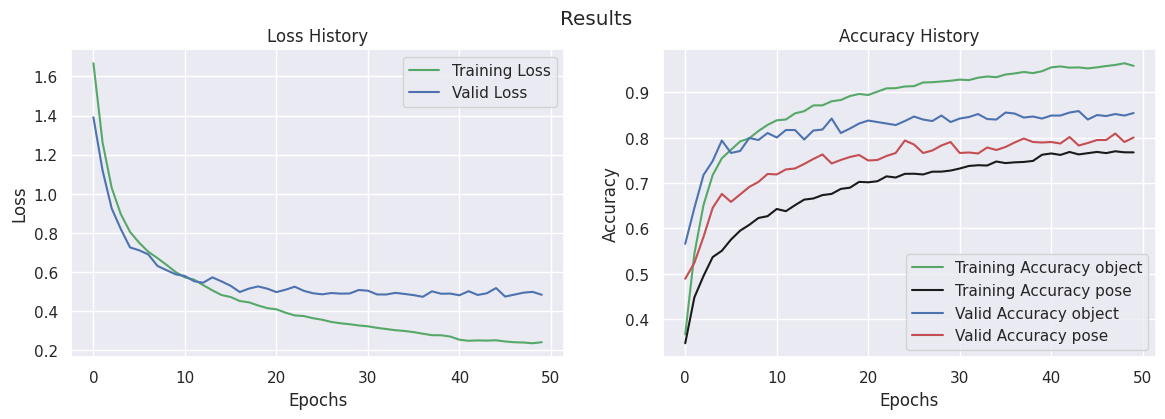

In [39]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history5 = trainer5.getHistory()
trainer5.showResults()

best model was trained at epoch: 44
with a validation loss of: 0.49158174 and a validation accuracy of: 85.90308427810669


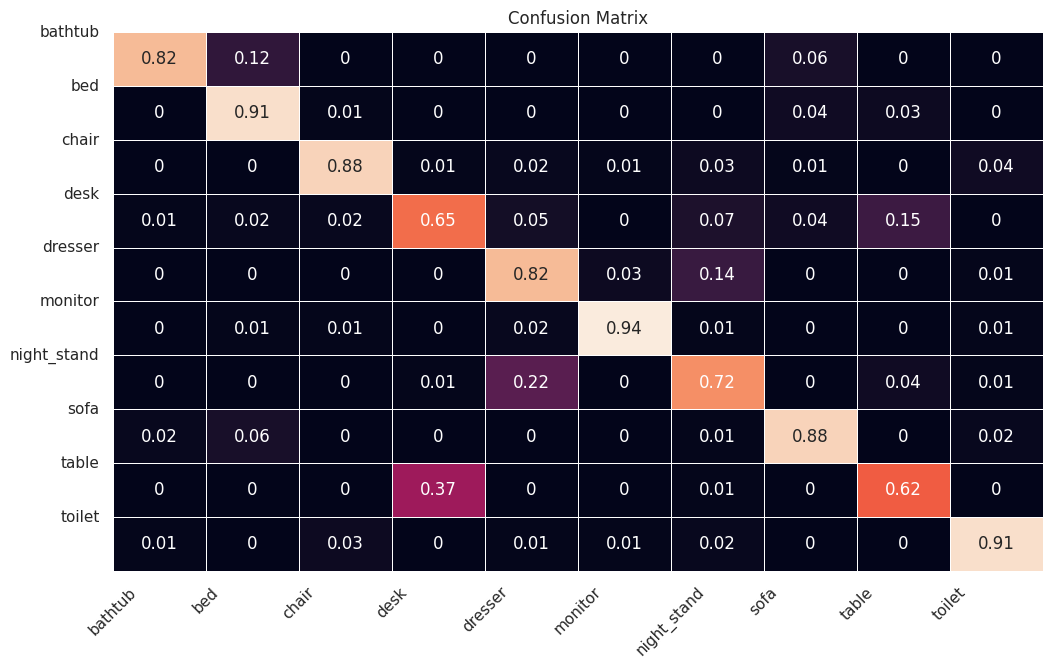

In [40]:
trainer5.generateConfusionMatrix()

best model was trained at epoch: 44
with a validation loss of: 0.49158174 and a validation accuracy of: 85.90308427810669


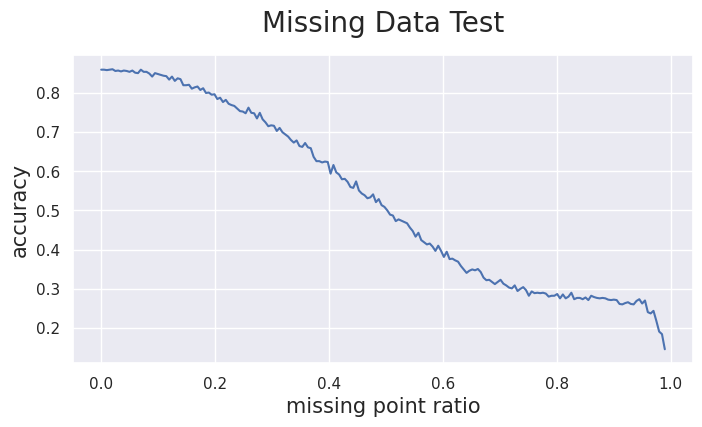

In [41]:
trainer5.missing_data_test()

In [42]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet_a'
}    

trainer6 = VoxNet_Trainer_a(training_hyperparameters)
trainer6.train()

model DMPVoxNet was choosen
125.0


Train loss: 1.3720422983169556: : 125it [01:02,  2.01it/s]
29it [00:03,  8.10it/s]


epoch:  1 / 50
time: 65.86 seconds
train-loss: 1.78, train-acc-object: 33.52%, train-acc-pose: 30.00%
valid-loss: 1.53, valid-acc-object: 53.19%, train-acc-pose: 50.22%



Train loss: 0.9852569699287415: : 125it [01:02,  2.01it/s]
29it [00:03,  8.27it/s]


epoch:  2 / 50
time: 65.72 seconds
train-loss: 1.12, train-acc-object: 58.51%, train-acc-pose: 49.08%
valid-loss: 1.21, valid-acc-object: 75.88%, train-acc-pose: 59.14%



Train loss: 0.7531241774559021: : 125it [01:02,  2.02it/s]
29it [00:03,  7.96it/s]


epoch:  3 / 50
time: 65.69 seconds
train-loss: 0.86, train-acc-object: 71.47%, train-acc-pose: 56.42%
valid-loss: 0.94, valid-acc-object: 76.65%, train-acc-pose: 65.86%



Train loss: 0.542756199836731: : 125it [01:01,  2.02it/s]
29it [00:03,  7.30it/s]


epoch:  4 / 50
time: 65.93 seconds
train-loss: 0.68, train-acc-object: 78.59%, train-acc-pose: 61.75%
valid-loss: 0.79, valid-acc-object: 78.85%, train-acc-pose: 67.29%



Train loss: 0.5878942608833313: : 125it [01:01,  2.03it/s]
29it [00:04,  6.95it/s]


epoch:  5 / 50
time: 65.75 seconds
train-loss: 0.60, train-acc-object: 81.38%, train-acc-pose: 63.84%
valid-loss: 0.77, valid-acc-object: 81.61%, train-acc-pose: 71.92%



Train loss: 0.3768693506717682: : 125it [01:01,  2.03it/s]
29it [00:04,  6.62it/s]


epoch:  6 / 50
time: 65.97 seconds
train-loss: 0.48, train-acc-object: 86.14%, train-acc-pose: 68.05%
valid-loss: 0.62, valid-acc-object: 80.07%, train-acc-pose: 74.34%



Train loss: 0.44672703742980957: : 125it [01:01,  2.03it/s]
29it [00:04,  6.28it/s]


epoch:  7 / 50
time: 66.13 seconds
train-loss: 0.42, train-acc-object: 87.89%, train-acc-pose: 69.64%
valid-loss: 0.58, valid-acc-object: 79.41%, train-acc-pose: 74.23%



Train loss: 0.30753400921821594: : 125it [01:01,  2.03it/s]
29it [00:04,  6.40it/s]


epoch:  8 / 50
time: 66.13 seconds
train-loss: 0.40, train-acc-object: 89.23%, train-acc-pose: 70.64%
valid-loss: 0.57, valid-acc-object: 82.05%, train-acc-pose: 74.34%



Train loss: 0.4173046052455902: : 125it [01:01,  2.04it/s]
29it [00:04,  6.26it/s]


epoch:  9 / 50
time: 66.00 seconds
train-loss: 0.38, train-acc-object: 90.15%, train-acc-pose: 70.67%
valid-loss: 0.53, valid-acc-object: 84.14%, train-acc-pose: 76.76%



Train loss: 0.4404948353767395: : 125it [01:01,  2.03it/s]
29it [00:04,  6.29it/s]


epoch: 10 / 50
time: 66.11 seconds
train-loss: 0.36, train-acc-object: 90.61%, train-acc-pose: 71.32%
valid-loss: 0.51, valid-acc-object: 82.93%, train-acc-pose: 75.00%



Train loss: 0.2782944440841675: : 125it [01:01,  2.03it/s]
29it [00:04,  6.38it/s]


epoch: 11 / 50
time: 66.04 seconds
train-loss: 0.31, train-acc-object: 93.12%, train-acc-pose: 73.59%
valid-loss: 0.47, valid-acc-object: 84.25%, train-acc-pose: 76.76%



Train loss: 0.2926010489463806: : 125it [01:01,  2.03it/s]
29it [00:04,  6.71it/s]


epoch: 12 / 50
time: 65.79 seconds
train-loss: 0.30, train-acc-object: 93.29%, train-acc-pose: 73.76%
valid-loss: 0.50, valid-acc-object: 81.17%, train-acc-pose: 77.64%



Train loss: 0.3674457371234894: : 125it [01:01,  2.02it/s]
29it [00:04,  6.54it/s]


epoch: 13 / 50
time: 66.30 seconds
train-loss: 0.29, train-acc-object: 93.45%, train-acc-pose: 74.18%
valid-loss: 0.48, valid-acc-object: 80.84%, train-acc-pose: 77.20%



Train loss: 0.24550145864486694: : 125it [01:02,  2.00it/s]
29it [00:04,  6.28it/s]


epoch: 14 / 50
time: 67.09 seconds
train-loss: 0.28, train-acc-object: 94.05%, train-acc-pose: 73.25%
valid-loss: 0.47, valid-acc-object: 84.14%, train-acc-pose: 76.87%



Train loss: 0.22190432250499725: : 125it [01:02,  2.01it/s]
29it [00:04,  5.98it/s]


epoch: 15 / 50
time: 67.15 seconds
train-loss: 0.27, train-acc-object: 94.39%, train-acc-pose: 74.29%
valid-loss: 0.46, valid-acc-object: 83.59%, train-acc-pose: 78.30%



Train loss: 0.207341730594635: : 125it [01:01,  2.02it/s]
29it [00:04,  6.16it/s]


epoch: 16 / 50
time: 66.61 seconds
train-loss: 0.25, train-acc-object: 95.35%, train-acc-pose: 74.99%
valid-loss: 0.45, valid-acc-object: 83.15%, train-acc-pose: 78.41%



Train loss: 0.24891898036003113: : 125it [01:01,  2.05it/s]
29it [00:04,  6.19it/s]


epoch: 17 / 50
time: 65.77 seconds
train-loss: 0.24, train-acc-object: 95.44%, train-acc-pose: 75.74%
valid-loss: 0.44, valid-acc-object: 84.69%, train-acc-pose: 77.53%



Train loss: 0.19485928118228912: : 125it [01:02,  2.02it/s]
29it [00:04,  6.14it/s]


epoch: 18 / 50
time: 66.74 seconds
train-loss: 0.23, train-acc-object: 95.86%, train-acc-pose: 75.79%
valid-loss: 0.44, valid-acc-object: 83.48%, train-acc-pose: 78.41%



Train loss: 0.22110845148563385: : 125it [01:01,  2.02it/s]
29it [00:04,  5.91it/s]


epoch: 19 / 50
time: 66.65 seconds
train-loss: 0.23, train-acc-object: 96.28%, train-acc-pose: 75.73%
valid-loss: 0.44, valid-acc-object: 83.37%, train-acc-pose: 78.19%



Train loss: 0.2948525547981262: : 125it [01:02,  2.01it/s]
29it [00:04,  6.43it/s]


epoch: 20 / 50
time: 66.67 seconds
train-loss: 0.23, train-acc-object: 95.78%, train-acc-pose: 75.76%
valid-loss: 0.44, valid-acc-object: 85.02%, train-acc-pose: 78.41%



Train loss: 0.19617758691310883: : 125it [01:00,  2.05it/s]
29it [00:04,  6.31it/s]


epoch: 21 / 50
time: 65.60 seconds
train-loss: 0.22, train-acc-object: 96.61%, train-acc-pose: 77.51%
valid-loss: 0.43, valid-acc-object: 84.03%, train-acc-pose: 78.63%



Train loss: 0.2456444352865219: : 125it [01:01,  2.04it/s]
29it [00:04,  6.30it/s]


epoch: 22 / 50
time: 66.01 seconds
train-loss: 0.21, train-acc-object: 96.61%, train-acc-pose: 76.89%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.41%



Train loss: 0.19234095513820648: : 125it [01:01,  2.04it/s]
29it [00:04,  6.28it/s]


epoch: 23 / 50
time: 65.95 seconds
train-loss: 0.21, train-acc-object: 96.80%, train-acc-pose: 77.47%
valid-loss: 0.44, valid-acc-object: 83.70%, train-acc-pose: 79.07%



Train loss: 0.2103193998336792: : 125it [01:01,  2.03it/s]
29it [00:04,  6.39it/s]


epoch: 24 / 50
time: 66.12 seconds
train-loss: 0.21, train-acc-object: 96.94%, train-acc-pose: 77.21%
valid-loss: 0.43, valid-acc-object: 85.57%, train-acc-pose: 79.52%



Train loss: 0.20048221945762634: : 125it [01:01,  2.03it/s]
29it [00:04,  6.33it/s]


epoch: 25 / 50
time: 66.10 seconds
train-loss: 0.21, train-acc-object: 96.81%, train-acc-pose: 77.50%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.19%



Train loss: 0.17268230020999908: : 125it [01:01,  2.03it/s]
29it [00:04,  6.28it/s]


epoch: 26 / 50
time: 66.25 seconds
train-loss: 0.20, train-acc-object: 96.96%, train-acc-pose: 77.24%
valid-loss: 0.43, valid-acc-object: 85.46%, train-acc-pose: 78.30%



Train loss: 0.16428910195827484: : 125it [01:01,  2.03it/s]
29it [00:04,  6.57it/s]


epoch: 27 / 50
time: 66.03 seconds
train-loss: 0.20, train-acc-object: 97.32%, train-acc-pose: 77.42%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 78.96%



Train loss: 0.22087471187114716: : 125it [01:01,  2.03it/s]
29it [00:04,  6.62it/s]


epoch: 28 / 50
time: 65.98 seconds
train-loss: 0.20, train-acc-object: 97.29%, train-acc-pose: 78.10%
valid-loss: 0.43, valid-acc-object: 85.57%, train-acc-pose: 78.41%



Train loss: 0.21601173281669617: : 125it [01:01,  2.03it/s]
29it [00:04,  6.81it/s]


epoch: 29 / 50
time: 65.89 seconds
train-loss: 0.20, train-acc-object: 97.21%, train-acc-pose: 77.84%
valid-loss: 0.42, valid-acc-object: 85.13%, train-acc-pose: 78.96%



Train loss: 0.1564992219209671: : 125it [01:02,  2.01it/s]
29it [00:04,  6.51it/s]


epoch: 30 / 50
time: 66.54 seconds
train-loss: 0.20, train-acc-object: 97.26%, train-acc-pose: 77.57%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.19%



Train loss: 0.1338425576686859: : 125it [01:02,  2.02it/s]
29it [00:04,  6.71it/s]


epoch: 31 / 50
time: 66.37 seconds
train-loss: 0.20, train-acc-object: 97.30%, train-acc-pose: 78.07%
valid-loss: 0.43, valid-acc-object: 85.13%, train-acc-pose: 79.19%



Train loss: 0.15089675784111023: : 125it [01:02,  2.01it/s]
29it [00:04,  6.10it/s]


epoch: 32 / 50
time: 67.03 seconds
train-loss: 0.19, train-acc-object: 97.24%, train-acc-pose: 78.01%
valid-loss: 0.43, valid-acc-object: 85.46%, train-acc-pose: 78.63%



Train loss: 0.24871699512004852: : 125it [01:03,  1.98it/s]
29it [00:04,  5.95it/s]


epoch: 33 / 50
time: 67.96 seconds
train-loss: 0.20, train-acc-object: 97.35%, train-acc-pose: 77.21%
valid-loss: 0.42, valid-acc-object: 85.35%, train-acc-pose: 79.74%



Train loss: 0.19970765709877014: : 125it [01:03,  1.97it/s]
29it [00:04,  6.64it/s]


epoch: 34 / 50
time: 67.82 seconds
train-loss: 0.19, train-acc-object: 97.41%, train-acc-pose: 78.19%
valid-loss: 0.43, valid-acc-object: 85.02%, train-acc-pose: 79.52%



Train loss: 0.16572305560112: : 125it [01:03,  1.96it/s]
29it [00:03,  7.84it/s]


epoch: 35 / 50
time: 67.40 seconds
train-loss: 0.19, train-acc-object: 97.29%, train-acc-pose: 77.71%
valid-loss: 0.42, valid-acc-object: 85.79%, train-acc-pose: 78.96%



Train loss: 0.16909977793693542: : 125it [01:03,  1.96it/s]
29it [00:03,  7.63it/s]


epoch: 36 / 50
time: 67.66 seconds
train-loss: 0.19, train-acc-object: 97.54%, train-acc-pose: 78.12%
valid-loss: 0.43, valid-acc-object: 85.35%, train-acc-pose: 79.30%



Train loss: 0.12160110473632812: : 125it [01:04,  1.95it/s]
29it [00:03,  7.33it/s]


epoch: 37 / 50
time: 68.10 seconds
train-loss: 0.19, train-acc-object: 97.45%, train-acc-pose: 78.51%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.30%



Train loss: 0.2848282754421234: : 125it [01:04,  1.94it/s]
29it [00:04,  7.24it/s]


epoch: 38 / 50
time: 68.45 seconds
train-loss: 0.19, train-acc-object: 97.26%, train-acc-pose: 78.36%
valid-loss: 0.43, valid-acc-object: 84.69%, train-acc-pose: 79.52%



Train loss: 0.21055977046489716: : 125it [01:04,  1.94it/s]
29it [00:04,  6.96it/s]


epoch: 39 / 50
time: 68.46 seconds
train-loss: 0.19, train-acc-object: 97.46%, train-acc-pose: 78.57%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.96%



Train loss: 0.15654420852661133: : 125it [01:03,  1.96it/s]
29it [00:04,  6.08it/s]


epoch: 40 / 50
time: 68.47 seconds
train-loss: 0.19, train-acc-object: 97.72%, train-acc-pose: 78.40%
valid-loss: 0.43, valid-acc-object: 85.02%, train-acc-pose: 79.96%



Train loss: 0.18166911602020264: : 125it [01:03,  1.97it/s]
29it [00:04,  5.93it/s]


epoch: 41 / 50
time: 68.28 seconds
train-loss: 0.19, train-acc-object: 97.45%, train-acc-pose: 78.25%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.63%



Train loss: 0.26934701204299927: : 125it [01:04,  1.93it/s]
29it [00:03,  7.67it/s]


epoch: 42 / 50
time: 68.48 seconds
train-loss: 0.19, train-acc-object: 97.46%, train-acc-pose: 79.16%
valid-loss: 0.43, valid-acc-object: 85.35%, train-acc-pose: 79.19%



Train loss: 0.20120546221733093: : 125it [01:04,  1.94it/s]
29it [00:03,  7.67it/s]


epoch: 43 / 50
time: 68.22 seconds
train-loss: 0.19, train-acc-object: 97.53%, train-acc-pose: 78.72%
valid-loss: 0.43, valid-acc-object: 84.91%, train-acc-pose: 79.52%



Train loss: 0.15040963888168335: : 125it [01:05,  1.91it/s]
29it [00:04,  7.02it/s]


epoch: 44 / 50
time: 69.66 seconds
train-loss: 0.19, train-acc-object: 97.37%, train-acc-pose: 78.84%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.41%



Train loss: 0.2135544866323471: : 125it [01:04,  1.95it/s]
29it [00:03,  7.48it/s]


epoch: 45 / 50
time: 67.99 seconds
train-loss: 0.19, train-acc-object: 97.44%, train-acc-pose: 78.16%
valid-loss: 0.43, valid-acc-object: 84.91%, train-acc-pose: 79.85%



Train loss: 0.21518036723136902: : 125it [01:03,  1.95it/s]
29it [00:04,  6.71it/s]


epoch: 46 / 50
time: 68.29 seconds
train-loss: 0.19, train-acc-object: 97.45%, train-acc-pose: 78.50%
valid-loss: 0.43, valid-acc-object: 85.13%, train-acc-pose: 79.85%



Train loss: 0.18544957041740417: : 125it [01:03,  1.97it/s]
29it [00:04,  5.94it/s]


epoch: 47 / 50
time: 68.41 seconds
train-loss: 0.19, train-acc-object: 97.49%, train-acc-pose: 78.80%
valid-loss: 0.43, valid-acc-object: 85.02%, train-acc-pose: 79.85%



Train loss: 0.23403683304786682: : 125it [01:03,  1.98it/s]
29it [00:03,  7.61it/s]


epoch: 48 / 50
time: 67.10 seconds
train-loss: 0.19, train-acc-object: 97.40%, train-acc-pose: 79.08%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.85%



Train loss: 0.22880545258522034: : 125it [01:02,  1.99it/s]
29it [00:03,  7.71it/s]


epoch: 49 / 50
time: 66.74 seconds
train-loss: 0.19, train-acc-object: 97.58%, train-acc-pose: 78.90%
valid-loss: 0.43, valid-acc-object: 85.24%, train-acc-pose: 79.74%



Train loss: 0.2271054983139038: : 125it [01:02,  1.98it/s]
29it [00:04,  6.29it/s]

epoch: 50 / 50
time: 67.62 seconds
train-loss: 0.19, train-acc-object: 97.45%, train-acc-pose: 78.53%
valid-loss: 0.43, valid-acc-object: 85.35%, train-acc-pose: 79.85%



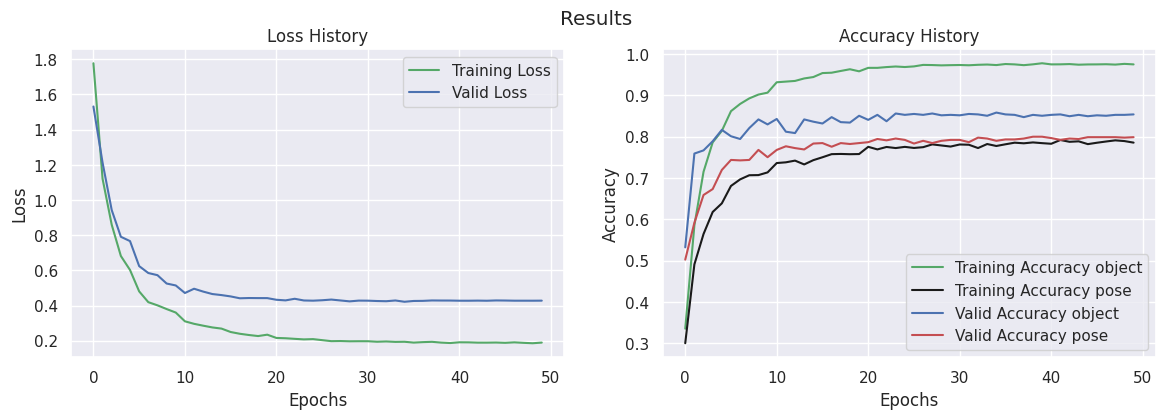

In [43]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history6 = trainer6.getHistory()
trainer6.showResults()

best model was trained at epoch: 10
with a validation loss of: 0.6204222 and a validation accuracy of: 85.0220263004303


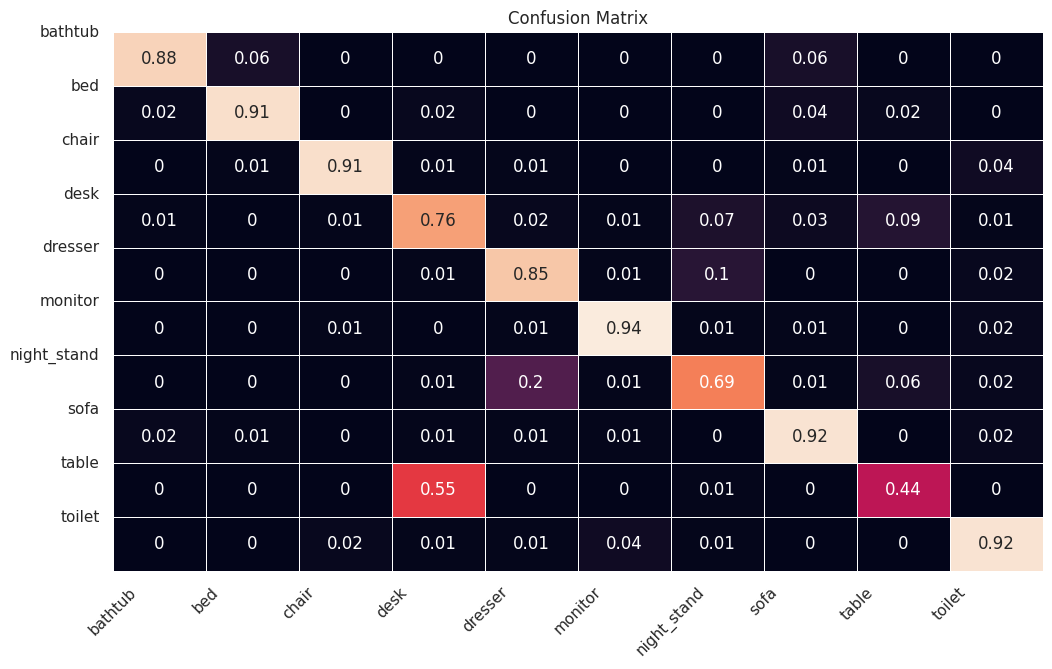

In [ ]:
trainer6.generateConfusionMatrix()

best model was trained at epoch: 35
with a validation loss of: 0.42145103 and a validation accuracy of: 85.7929527759552


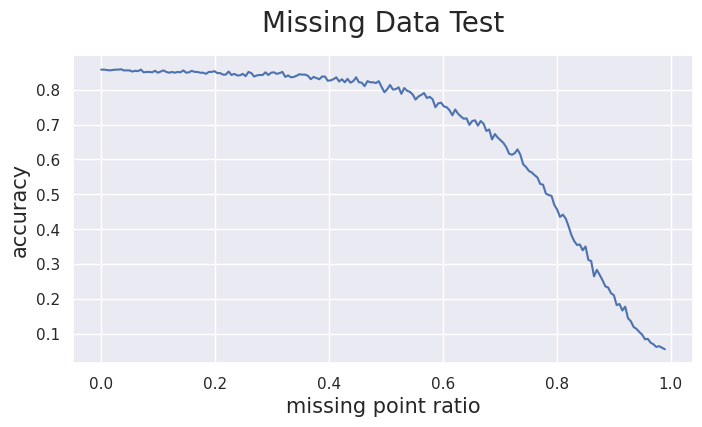

In [44]:
trainer6.missing_data_test()

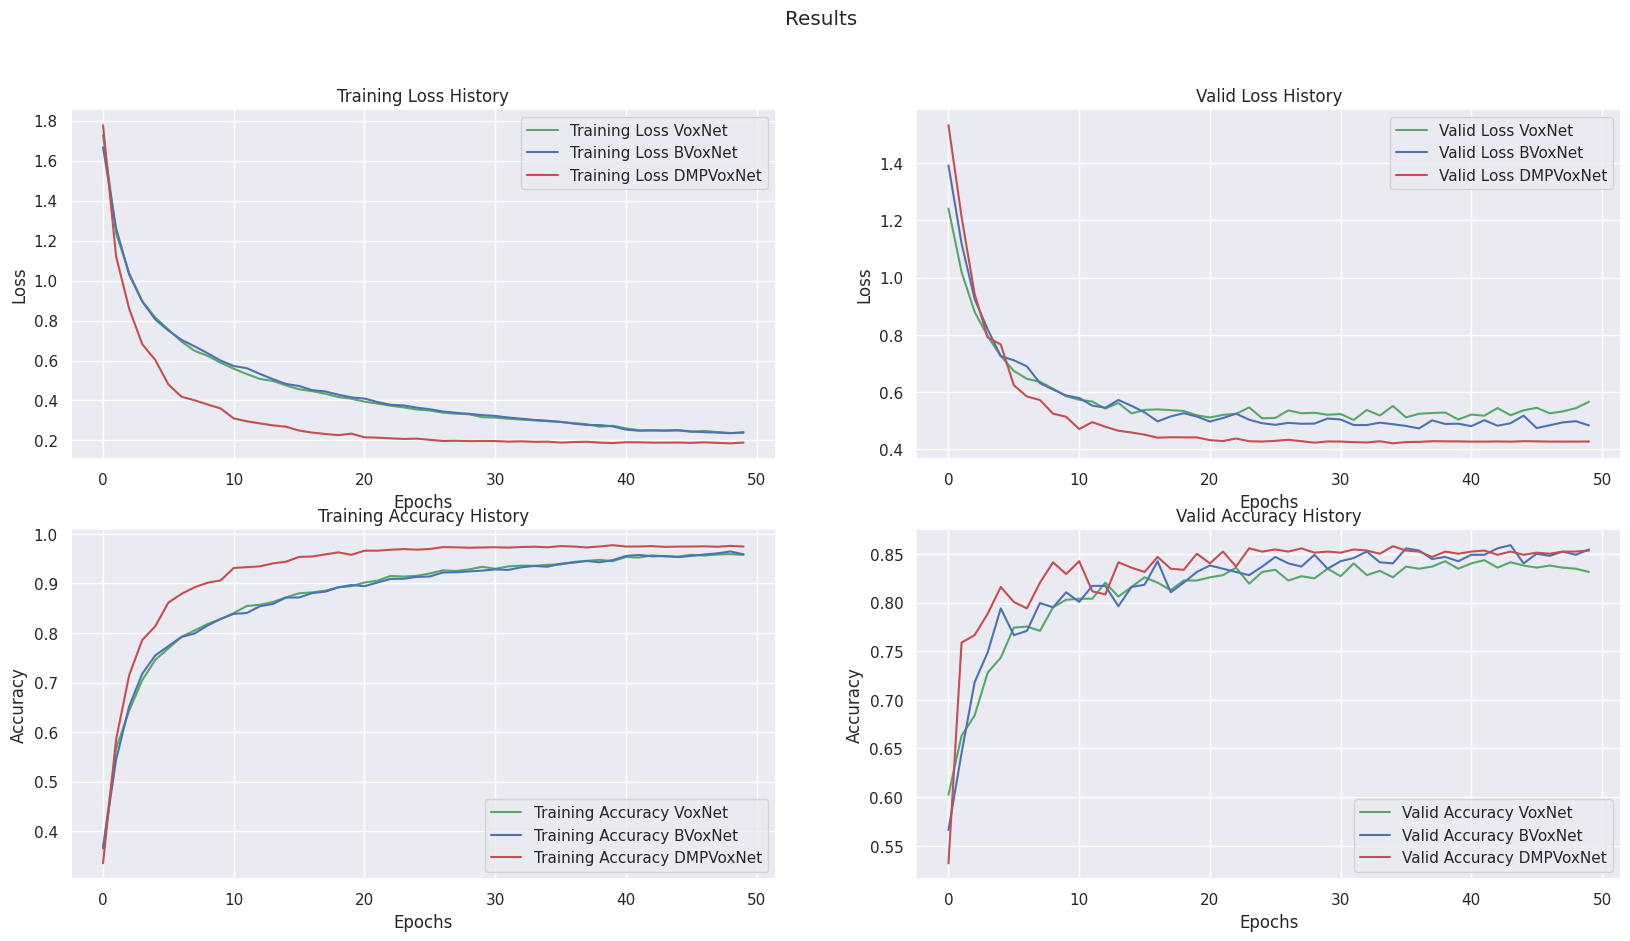

In [45]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history4["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history4["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history5["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history6["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history4["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history5["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history6["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history4["train_acc1"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history5["train_acc1"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history6["train_acc1"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history4["valid_acc1"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history5["valid_acc1"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history6["valid_acc1"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# PointNet

In [ ]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))  # torch.Size([256, 10])
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)
                
                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "data_size": 32,
    "epochs": 20,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}    

trainer7 = PointNet_Trainer(training_hyperparameters)
trainer7.train()

NameError: ignored

# Download and unzip the dataset ModelNet40



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/ModelNet40.zip";

In [ ]:
!wget http://modelnet.cs.princeton.edu/ModelNet40.zip

--2023-05-19 08:16:39--  http://modelnet.cs.princeton.edu/ModelNet40.zip
Resolving modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)... 128.112.136.74
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://modelnet.cs.princeton.edu/ModelNet40.zip [following]
--2023-05-19 08:16:40--  https://modelnet.cs.princeton.edu/ModelNet40.zip
Connecting to modelnet.cs.princeton.edu (modelnet.cs.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2039180837 (1.9G) [application/zip]
Saving to: ‘ModelNet40.zip’

ModelNet40.zip      100%[===================>]   1.90G  56.9MB/s    in 53s     

2023-05-19 08:17:32 (37.0 MB/s) - ‘ModelNet40.zip’ saved [2039180837/2039180837]



In [ ]:
!unzip -q ModelNet40.zip;

In [ ]:
ROOT = '/content/ModelNet40/'
CLASSES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
           'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
           'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
           'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

ROTATIONS = ['0', '45', '90', '135', '180', '225', '270', '315']

#rotations matrix
r45 = np.array([[math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)
r90 = np.array([[0,-1,0], [1,0,0], [0,0,1]], np.float64)
r135 = np.array([[-math.sqrt(2)/2,-math.sqrt(2)/2,0], [math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r180 = np.array([[-1,0,0], [0,-1,0], [0,0,1]], np.float64)
r225 = np.array([[-math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,-math.sqrt(2)/2,0], [0,0,1]], np.float64)
r270 = np.array([[0,1,0], [-1,0,0], [0,0,1]], np.float64)
r315 = np.array([[math.sqrt(2)/2,math.sqrt(2)/2,0], [-math.sqrt(2)/2,math.sqrt(2)/2,0], [0,0,1]], np.float64)

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}
Z = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          rot = random.choice(ROTATIONS)
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            if rot == '0':
              mesh = mesh
              rotat = 0
            elif rot == '45':
              mesh.rotate(r45)
              rotat = 1
            elif rot == '90':
              mesh.rotate(r90)
              rotat = 2
            elif rot == '135':
              mesh.rotate(r135) 
              rotat = 3 
            elif rot == '180':
              mesh.rotate(r180)
              rotat = 4
            elif rot == '225':
              mesh.rotate(r225)
              rotat = 5
            elif rot == '270':
              mesh.rotate(r270)
              rotat = 6
            else:
              mesh.rotate(r315)
              rotat = 7
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)
            Z[split].append(rotat)


  4%|▍         | 21/515 [00:00<00:23, 21.47it/s]<ipython-input-5-c756dd08d0a1>:54: RuntimeWarning: divide by zero encountered in double_scalars
  mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
  5%|▌         | 27/515 [00:00<00:18, 27.01it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4780 6240 0' not supported.


 19%|█▉        | 97/515 [00:03<00:13, 30.18it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF3161 2820 0' not supported.


 28%|██▊       | 142/515 [00:05<00:13, 28.13it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18524 23092 0' not supported.


 62%|██████▏   | 319/515 [00:12<00:06, 28.62it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1479 1440 0' not supported.


 65%|██████▍   | 334/515 [00:13<00:07, 23.73it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1806 1388 0' not supported.


 21%|██        | 187/889 [00:08<00:13, 51.61it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF2938 4636 0' not supported.


 56%|█████▋    | 502/889 [00:17<00:08, 48.15it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF4890 7376 0' not supported.


 77%|███████▋  | 682/889 [00:27<00:04, 49.09it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF18515 26870 0' not supported.


 94%|█████████▍| 837/889 [00:33<00:02, 21.48it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF6586 5534 0' not supported.


 35%|███▍      | 30/86 [00:00<00:00, 105.55it/s]

[Open3D WARNING] Read OFF failed: header keyword 'OFF1' not supported.


100%|██████████| 20/20 [00:01<00:00, 14.93it/s]


#VoxNet with Modelnet40

In [ ]:
class VoxelDataset40(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label1 = Y['train']
          self.label2 = Z['train']
      else:
          self.data = X['test']
          self.label1 = Y['test']
          self.label2 = Z['test']
        
                
    def __len__(self):
        return len(self.label1)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label1 = self.label1[idx]
        label2 = self.label2[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label1, label2

In [ ]:
class VoxNet_Trainer40():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      self.name_model = hyperparameters["model"]
      self.best_acc = 0
      self.alpha = 2/3
      
      #Dataset
      self.initDataset()
      self.class_names = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone',
                          'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp',
                          'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink',
                          'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']

      self.rotation_names = ['0', '45', '90', '135', '180', '225', '270', '315']
      self.num_classes = len(self.class_names)
      self.num_rotations = len(self.rotation_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset40(train=True)
      self.test_ds = VoxelDataset40(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      self.model = VoxNet40()
      os.mkdir('/content/'+str(self.name_model))
      print('model VoxNet40 was choosen')
      self.model.to(self.device)
      
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.loss_fn = nn.CrossEntropyLoss()
      #self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)
      #self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(self.opt, start_factor=1, end_factor=0.05, total_iters=50)


  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history1, valid_acc_history1 = [], []
      train_acc_history2, valid_acc_history2 = [], []
      train_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      valid_accuracy1 = Accuracy(task='multiclass', num_classes=self.num_classes)
      train_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)
      valid_accuracy2 = Accuracy(task='multiclass', num_classes=self.num_rotations)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          #track training and validation loss
          train_loss = []                                                        
          valid_loss = []

          #training phase
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels1, labels2 = data[0], data[1], data[2]
              inputs = inputs.to(self.device)
              labels1 = labels1.to(self.device)
              labels2 = labels2.to(self.device)

              self.opt.zero_grad()
              pred1, pred2 = self.model(inputs)  # torch.Size([256, 10])
              loss = self.alpha*self.loss_fn(pred1, labels1) + (1-self.alpha)*self.loss_fn(pred2, labels2)
              train_loss.append(loss.cpu().data)
              train_accuracy1.update(torch.argmax(pred1, 1).cpu(), labels1.cpu()) 
              train_accuracy2.update(torch.argmax(pred2, 1).cpu(), labels2.cpu()) 
            
              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
          self.lr_scheduler.step()

          #evaluation phase             
          with torch.no_grad():
            self.model.eval()
            pred_test1 = []       
            pred_test2 = []  
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test1, labels_test2 = sample[0], sample[1], sample[2]
                inputs_test = inputs_test.to(self.device)
                labels_test1 = labels_test1.to(self.device)
                labels_test2 = labels_test2.to(self.device)
                inputs_test = inputs_test.float()  
               
                pred_test1, pred_test2 = self.model(inputs_test)  
                loss_test = self.alpha*self.loss_fn(pred_test1, labels_test1) + (1-self.alpha)*self.loss_fn(pred_test2, labels_test2)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy1.update(torch.argmax(pred_test1, 1).cpu(), labels_test1.cpu()) 
                valid_accuracy2.update(torch.argmax(pred_test2, 1).cpu(), labels_test2.cpu()) 
                
                self.pred_conf.append(torch.argmax(pred_test1, 1))
                self.y_conf.append(labels_test1)
      

          #total accuracy over all batches
          total_train_accuracy1 = train_accuracy1.compute()
          total_train_accuracy2 = train_accuracy2.compute()
          total_valid_accuracy1 = valid_accuracy1.compute()
          total_valid_accuracy2 = valid_accuracy2.compute()
          train_accuracy1.reset()
          valid_accuracy1.reset()
          train_accuracy2.reset()
          valid_accuracy2.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history1.append(total_train_accuracy1)
          train_acc_history2.append(total_train_accuracy2)
          valid_acc_history1.append(total_valid_accuracy1)
          valid_acc_history2.append(total_valid_accuracy2)
          
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc-object: {:.2%}, train-acc-pose: {:.2%}".format(train_loss_history[epoch], train_acc_history1[epoch].item(), train_acc_history2[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc-object: {:.2%}, train-acc-pose: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history1[epoch].item(), valid_acc_history2[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")


          #save best model 
          if total_valid_accuracy1.numpy()>self.best_acc:
              self.best_acc = total_valid_accuracy1.numpy()
              torch.save({'epoch': epoch+1,
                          'model_state_dict': self.model.state_dict(),
                          'optimizer_state_dict': self.opt.state_dict(),
                          'loss': valid_loss_history[-1], 
                          'accuracy': total_valid_accuracy1},
	                        '/content/'+str(self.name_model)+'/best_model.pth')

          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc1": torch.tensor(train_acc_history1), "train_acc2": torch.tensor(train_acc_history2), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc1": torch.tensor(valid_acc_history1), "valid_acc2": torch.tensor(valid_acc_history2)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(acc.numpy()*100))
  
      #compute confusion matrix
      self.model.eval()
      a = torch.cat(self.pred_conf).cpu()
      b = torch.cat(self.y_conf).cpu()
      confmat = ConfusionMatrix(task='multiclass', num_classes=self.num_classes, normalize="true")
      self.conf_matrix = confmat(a, b)
      self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

      fig=plt.figure(figsize = (20,14))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc1"].cpu()), 'g', label='Training Accuracy object')
      ax[1].plot(eps, smooth(self.history["train_acc2"].cpu()), 'k', label='Training Accuracy pose')
      ax[1].plot(eps, smooth(self.history["valid_acc1"].cpu()), 'b', label='Valid Accuracy object')
      ax[1].plot(eps, smooth(self.history["valid_acc2"].cpu()), 'r', label='Valid Accuracy pose')
      ax[1].set_title('Accuracy History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=40)

      ##load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      acc = checkpoint['accuracy']
  
      self.model.eval()
      for x, y, z in self.test_dataloader:
          x, y, z = x.to(self.device), y.to(self.device), z.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)[0]
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)

      #load the model
      checkpoint = torch.load('/content/'+str(self.name_model)+'/best_model.pth')
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      loss = checkpoint['loss']
      epoch = checkpoint['epoch']
      accu = checkpoint['accuracy']
      print('best model was trained at epoch: '+str(epoch))
      print('with a validation loss of: '+str(loss.numpy())+' and a validation accuracy of: '+str(accu.numpy()*100))

      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
class VoxNet40(nn.Module):
    def __init__(self):
        super(VoxNet40, self).__init__()
        n_classes = 40
        n_rotations = 8
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=1)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1)),
            ('relu2', torch.nn.ReLU()),
            ('drop2', torch.nn.Dropout(p=0.2)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1)),
            ('relu3', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.3)),
            ('pool3', torch.nn.MaxPool3d(2)),
            ('conv3d_4', torch.nn.Conv3d(in_channels=128, out_channels=256,kernel_size=3, stride=1)),
            ('relu4', torch.nn.ReLU()),
            ('drop4', torch.nn.Dropout(p=0.4)),
            ('pool4', torch.nn.MaxPool3d(2))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.mlp2 = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_rotations))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x1 = self.mlp(x)
        x2 = self.mlp2(x)
        #return x1, x2
        return self.logsoftmax(x1), self.logsoftmax(x2)

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.01,
    "sgd_momentum": 0.9,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 5,
    "lr_scheduler_gamma": 0.5,
    "train_batch_size": 64,
    "valid_batch_size": 32,
    "model" : 'VoxNet40'
}    

trainer8 = VoxNet_Trainer40(training_hyperparameters)
trainer8.train()

model VoxNet40 was choosen
143.75


Train loss: 2.4392590522766113: : 143it [00:53,  2.69it/s]
77it [00:07,  9.72it/s]


epoch:  1 / 50
time: 61.05 seconds
train-loss: 2.85, train-acc-object: 16.17%, train-acc-pose: 14.75%
valid-loss: 2.74, valid-acc-object: 23.43%, train-acc-pose: 17.13%



Train loss: 2.17775821685791: : 143it [00:54,  2.64it/s]
77it [00:06, 11.22it/s]


epoch:  2 / 50
time: 60.97 seconds
train-loss: 2.29, train-acc-object: 30.68%, train-acc-pose: 20.44%
valid-loss: 2.54, valid-acc-object: 32.72%, train-acc-pose: 23.91%



Train loss: 1.7404485940933228: : 143it [00:53,  2.69it/s]
77it [00:06, 11.20it/s]


epoch:  3 / 50
time: 60.00 seconds
train-loss: 1.95, train-acc-object: 42.29%, train-acc-pose: 25.03%
valid-loss: 2.21, valid-acc-object: 49.01%, train-acc-pose: 29.35%



Train loss: 1.6870163679122925: : 143it [00:53,  2.68it/s]
77it [00:08,  9.28it/s]


epoch:  4 / 50
time: 61.76 seconds
train-loss: 1.71, train-acc-object: 50.44%, train-acc-pose: 29.91%
valid-loss: 2.00, valid-acc-object: 52.86%, train-acc-pose: 31.99%



Train loss: 1.3589650392532349: : 143it [00:53,  2.65it/s]
77it [00:08,  8.71it/s]


epoch:  5 / 50
time: 62.75 seconds
train-loss: 1.54, train-acc-object: 55.79%, train-acc-pose: 34.42%
valid-loss: 1.89, valid-acc-object: 57.61%, train-acc-pose: 34.88%



Train loss: 1.2025798559188843: : 143it [00:54,  2.65it/s]
77it [00:08,  9.38it/s]


epoch:  6 / 50
time: 62.29 seconds
train-loss: 1.34, train-acc-object: 62.96%, train-acc-pose: 38.14%
valid-loss: 1.75, valid-acc-object: 66.10%, train-acc-pose: 38.21%



Train loss: 1.1050481796264648: : 143it [00:55,  2.59it/s]
77it [00:07, 10.20it/s]


epoch:  7 / 50
time: 62.75 seconds
train-loss: 1.28, train-acc-object: 64.65%, train-acc-pose: 40.34%
valid-loss: 1.69, valid-acc-object: 65.41%, train-acc-pose: 37.03%



Train loss: 0.9624826908111572: : 143it [00:53,  2.65it/s]
77it [00:10,  7.24it/s]


epoch:  8 / 50
time: 64.64 seconds
train-loss: 1.21, train-acc-object: 67.00%, train-acc-pose: 42.07%
valid-loss: 1.64, valid-acc-object: 68.90%, train-acc-pose: 38.65%



Train loss: 1.182276964187622: : 143it [00:53,  2.69it/s]
77it [00:08,  8.68it/s]


epoch:  9 / 50
time: 62.02 seconds
train-loss: 1.16, train-acc-object: 68.83%, train-acc-pose: 42.68%
valid-loss: 1.54, valid-acc-object: 69.91%, train-acc-pose: 41.01%



Train loss: 1.0473697185516357: : 143it [00:54,  2.65it/s]
77it [00:07, 10.77it/s]


epoch: 10 / 50
time: 61.19 seconds
train-loss: 1.12, train-acc-object: 70.09%, train-acc-pose: 42.24%
valid-loss: 1.46, valid-acc-object: 72.19%, train-acc-pose: 40.36%



Train loss: 1.0980701446533203: : 143it [00:53,  2.66it/s]
77it [00:07, 10.48it/s]


epoch: 11 / 50
time: 61.18 seconds
train-loss: 1.04, train-acc-object: 73.21%, train-acc-pose: 44.60%
valid-loss: 1.47, valid-acc-object: 72.64%, train-acc-pose: 41.13%



Train loss: 1.2005534172058105: : 117it [00:44,  2.85it/s]

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history8 = trainer8.getHistory()
trainer8.showResults()

best model was trained at epoch: 43
with a validation loss of: 0.97666 and a validation accuracy of: 78.56273055076599


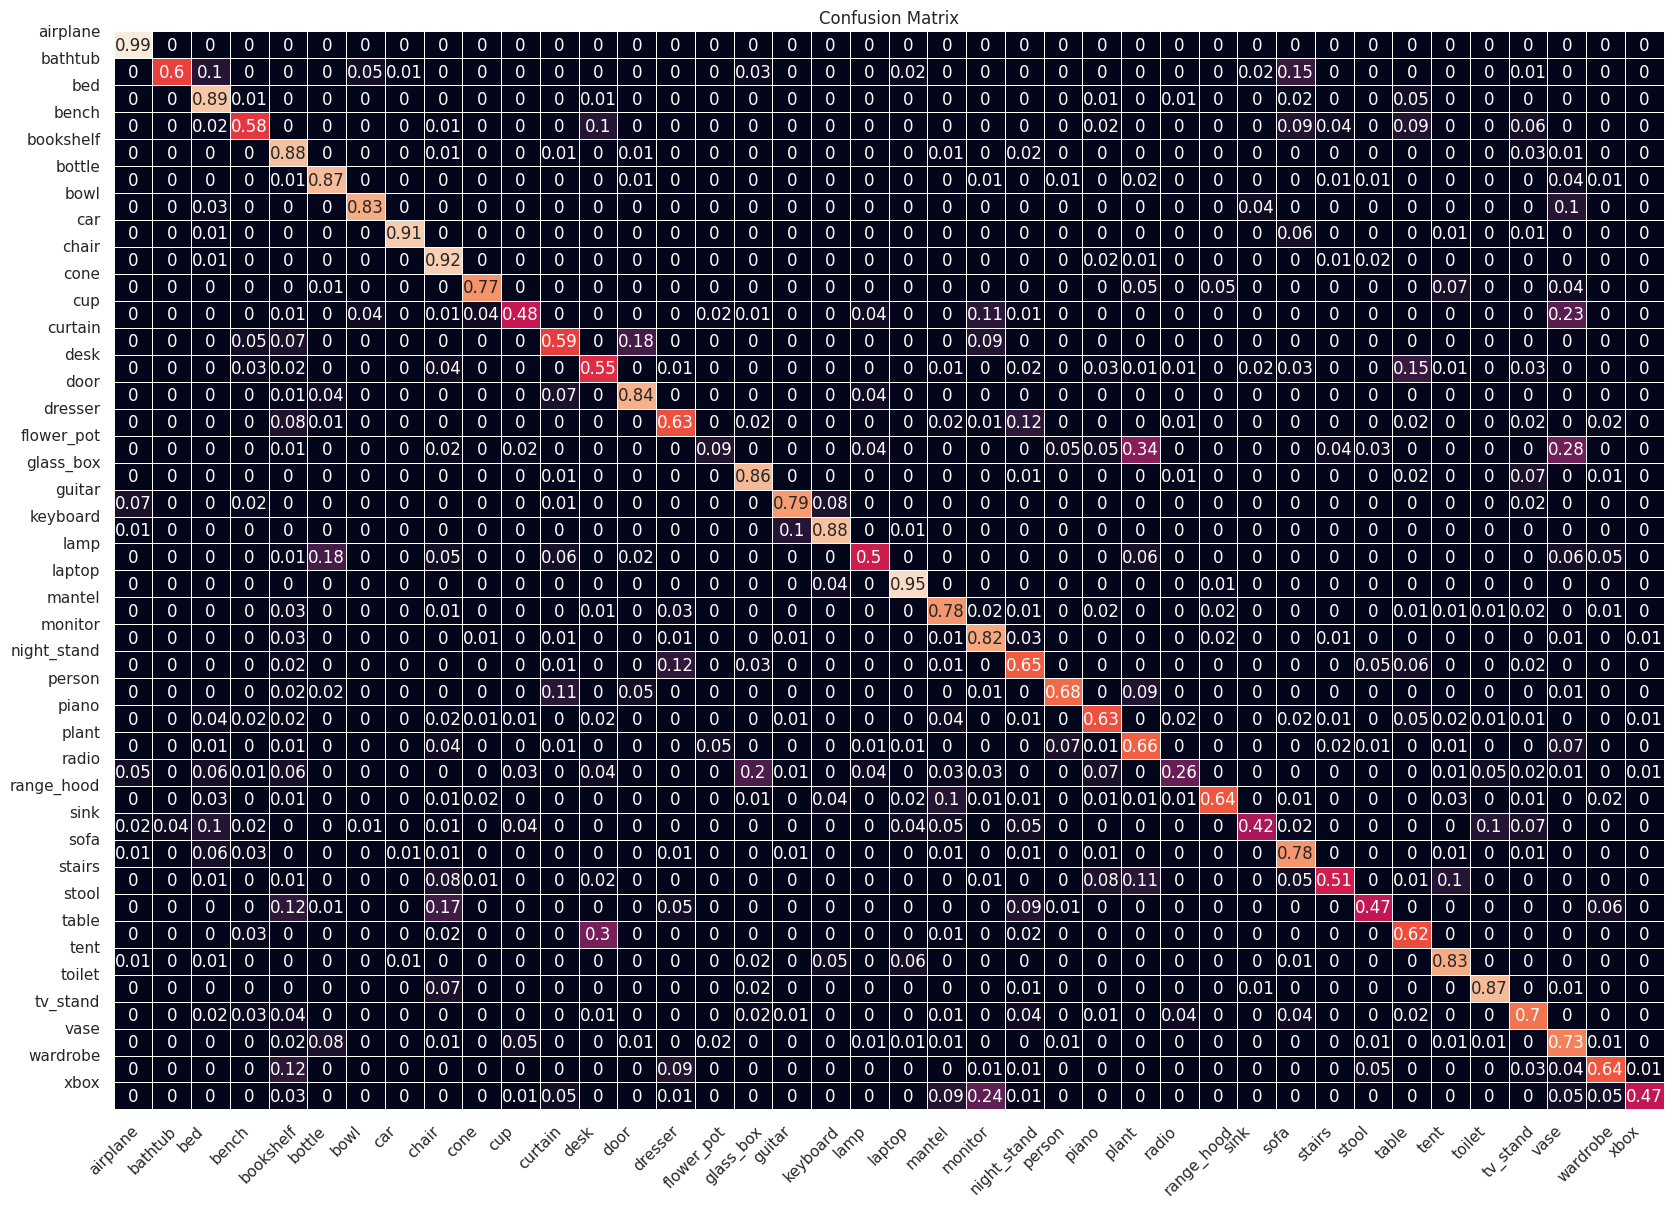

In [ ]:
trainer8.generateConfusionMatrix()